## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
import warnings
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

### Checks

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRico.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0*2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}

mie_mono_tables = OrderedDict()
for wavelength in [.66]:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')

true_geo_extinct = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)


%matplotlib inline
def plot(optimizer):
    py.figure()
    fig, axs = py.subplots(1, 2)
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            true_geo_extinct.ravel(),'x')
    axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[1].plot([0,30],[0,30])
    axs[1].axvline(x = np.nanmean(solvers[0.66].medium['cloud'].reff.data.ravel()), color = 'r', linestyle='--')
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)


In [6]:
solvers_reconstruct = at3d.containers.SolversDict()

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, optical_properties
)
def get_loss(reff_diff):
    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data + reff_diff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_diff
    return objective_function(x0)[0]
# losses = []
# for i in range(-10, 10):
#     losses.append(get_loss(i))
#     plot(None)
#     print(losses[i+10])
# py.plot(range(-10, 10),losses)


Text(0.5, 1.0, 'Loss vs Reff Using (Almost) Ground Truth Extinction')

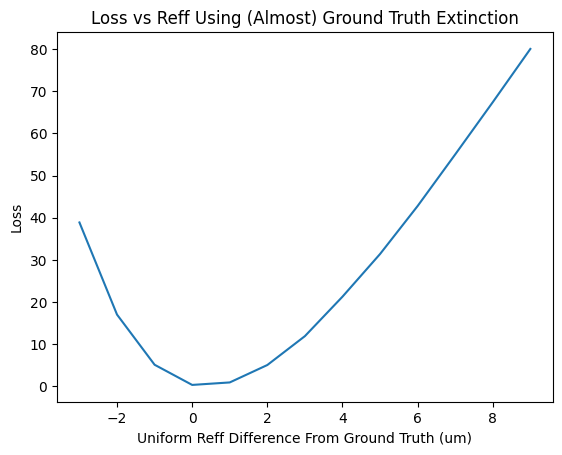

In [ ]:
py.plot(range(-3, 10), np.array(losses)[7:])
py.xlabel("Uniform Reff Difference From Ground Truth (um)")
py.ylabel("Loss")
py.title("Loss vs Reff Using (Almost) Ground Truth Extinction")

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.385E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.333  0.425E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.651  0.437E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.880  0.275E+00    32095    40.32  0.158   [Radiance 0.660 micron]
     5  -2.177  0.159E+00    32758    44.39  0.173   [Radiance 0.660 micron]
     6  -2.234  0.933E-01    34714    55.00  0.215   [Radiance 0.660 micron]
     7  -2.361  0.681E-01    37274    67.53  0.264   [Radiance 0.660 micron]
     8  -2.423  0.520E-01    40638    81.64  0.319   [Radiance 0.660 micron]
     9  -2.528  0.431E-01    44384    95.05  0.371   [Radiance 0.660 micron]
    10  -2.593  0.358E-01    49065   108.85  0.425   [Radiance 0.660 micron]
    11  -2.680  0.308E-01    53642   119.95  0.469   [Radiance 0.660 micron]
    12  -2.942  0.300E-01    54740   122.38  0.478   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

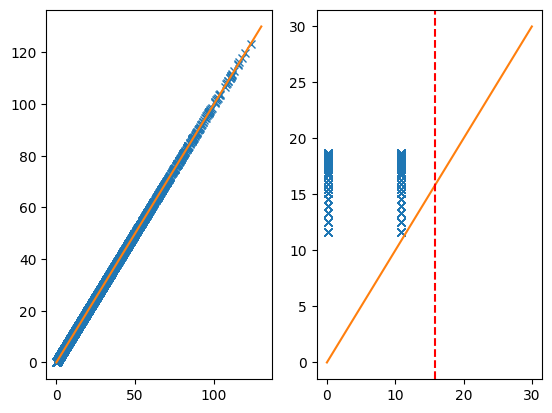

202.3426390100024
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.383E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.333  0.423E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.652  0.434E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.882  0.274E+00    32087    40.27  0.157   [Radiance 0.660 micron]
     5  -2.183  0.158E+00    32746    44.32  0.173   [Radiance 0.660 micron]
     6  -2.234  0.925E-01    34713    54.99  0.215   [Radiance 0.660 micron]
     7  -2.365  0.677E-01    37199    67.21  0.263   [Radiance 0.660 micron]
     8  -2.425  0.517E-01    40571    81.37  0.318   [Radiance 0.660 micron]
     9  -2.531  0.429E-01    44210    94.48  0.369   [Radiance 0.660 micron]
    10  -2.599  0.356E-01    48908   108.43  0.424   [Radiance 0.660 micron]
    11  -2.676  0.306E-01    53592   119.87  0.468   [Radiance 0.660 micron]
    12  -2.961  0.300E-01    54374   121.59  0.475   [Radianc

<Figure size 640x480 with 0 Axes>

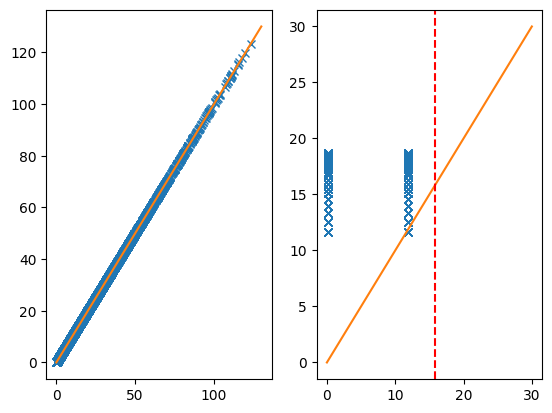

126.0585894575617
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.381E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.333  0.420E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.653  0.432E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.884  0.272E+00    32087    40.27  0.157   [Radiance 0.660 micron]
     5  -2.184  0.157E+00    32748    44.34  0.173   [Radiance 0.660 micron]
     6  -2.238  0.921E-01    34669    54.78  0.214   [Radiance 0.660 micron]
     7  -2.366  0.673E-01    37200    67.23  0.263   [Radiance 0.660 micron]
     8  -2.428  0.515E-01    40506    81.13  0.317   [Radiance 0.660 micron]
     9  -2.531  0.426E-01    44122    94.18  0.368   [Radiance 0.660 micron]
    10  -2.601  0.355E-01    48706   107.85  0.421   [Radiance 0.660 micron]
    11  -2.679  0.305E-01    53386   119.42  0.466   [Radiance 0.660 micron]
    12  -2.965  0.300E-01    54037   120.82  0.472   [Radianc

<Figure size 640x480 with 0 Axes>

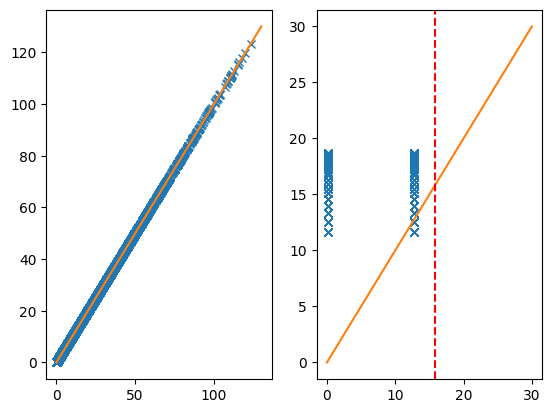

75.14472150690271
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.379E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.333  0.418E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.654  0.429E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.885  0.271E+00    32086    40.26  0.157   [Radiance 0.660 micron]
     5  -2.188  0.156E+00    32748    44.34  0.173   [Radiance 0.660 micron]
     6  -2.240  0.916E-01    34659    54.72  0.214   [Radiance 0.660 micron]
     7  -2.368  0.670E-01    37184    67.16  0.262   [Radiance 0.660 micron]
     8  -2.427  0.512E-01    40426    80.82  0.316   [Radiance 0.660 micron]
     9  -2.535  0.426E-01    43968    93.70  0.366   [Radiance 0.660 micron]
    10  -2.599  0.354E-01    48608   107.60  0.420   [Radiance 0.660 micron]
    11  -2.692  0.305E-01    53095   118.78  0.464   [Radiance 0.660 micron]
    12  -2.955  0.300E-01    53785   120.29  0.470   [Radianc

<Figure size 640x480 with 0 Axes>

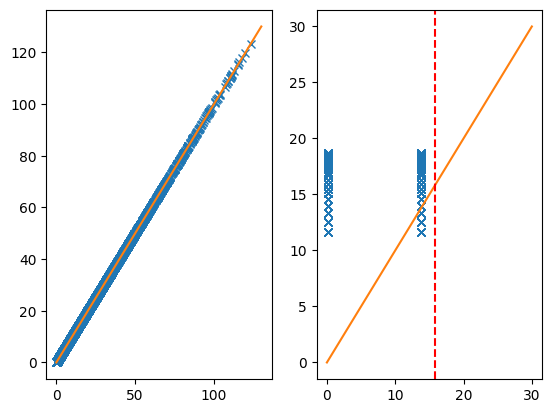

42.12988719157385
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.728  0.378E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.417E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.655  0.428E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.886  0.270E+00    32086    40.26  0.157   [Radiance 0.660 micron]
     5  -2.190  0.156E+00    32746    44.32  0.173   [Radiance 0.660 micron]
     6  -2.242  0.911E-01    34642    54.65  0.213   [Radiance 0.660 micron]
     7  -2.367  0.666E-01    37182    67.15  0.262   [Radiance 0.660 micron]
     8  -2.431  0.511E-01    40362    80.60  0.315   [Radiance 0.660 micron]
     9  -2.532  0.424E-01    43901    93.50  0.365   [Radiance 0.660 micron]
    10  -2.602  0.354E-01    48431   107.15  0.419   [Radiance 0.660 micron]
    11  -2.690  0.304E-01    52941   118.42  0.463   [Radiance 0.660 micron]
    12  -2.960  0.300E-01    53558   119.79  0.468   [Radianc

<Figure size 640x480 with 0 Axes>

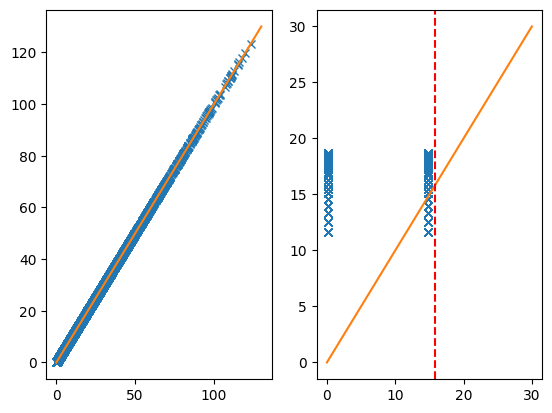

21.363628513430754
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.728  0.377E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.415E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.655  0.426E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.887  0.268E+00    32087    40.27  0.157   [Radiance 0.660 micron]
     5  -2.192  0.155E+00    32746    44.32  0.173   [Radiance 0.660 micron]
     6  -2.245  0.909E-01    34615    54.53  0.213   [Radiance 0.660 micron]
     7  -2.367  0.664E-01    37167    67.07  0.262   [Radiance 0.660 micron]
     8  -2.434  0.510E-01    40305    80.36  0.314   [Radiance 0.660 micron]
     9  -2.532  0.422E-01    43862    93.39  0.365   [Radiance 0.660 micron]
    10  -2.602  0.353E-01    48297   106.81  0.417   [Radiance 0.660 micron]
    11  -2.690  0.304E-01    52775   118.06  0.461   [Radiance 0.660 micron]
    12  -2.985  0.300E-01    53302   119.24  0.466   [Radian

<Figure size 640x480 with 0 Axes>

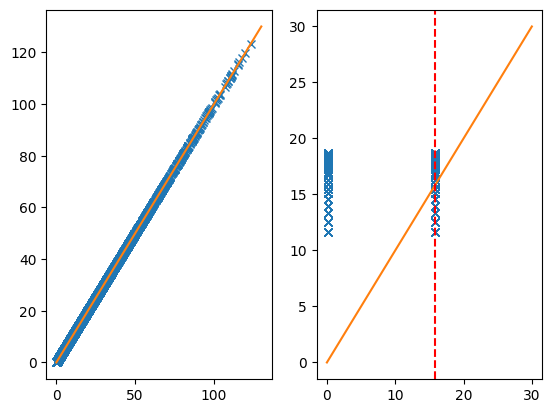

10.140824218413456
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.728  0.375E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.414E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.655  0.424E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.888  0.268E+00    32085    40.26  0.157   [Radiance 0.660 micron]
     5  -2.194  0.155E+00    32733    44.26  0.173   [Radiance 0.660 micron]
     6  -2.245  0.905E-01    34605    54.47  0.213   [Radiance 0.660 micron]
     7  -2.371  0.662E-01    37150    67.00  0.262   [Radiance 0.660 micron]
     8  -2.430  0.508E-01    40311    80.39  0.314   [Radiance 0.660 micron]
     9  -2.540  0.423E-01    43714    92.89  0.363   [Radiance 0.660 micron]
    10  -2.599  0.351E-01    48321   106.89  0.418   [Radiance 0.660 micron]
    11  -2.692  0.304E-01    52607   117.69  0.460   [Radiance 0.660 micron]
    12  -2.988  0.300E-01    53136   118.85  0.464   [Radian

<Figure size 640x480 with 0 Axes>

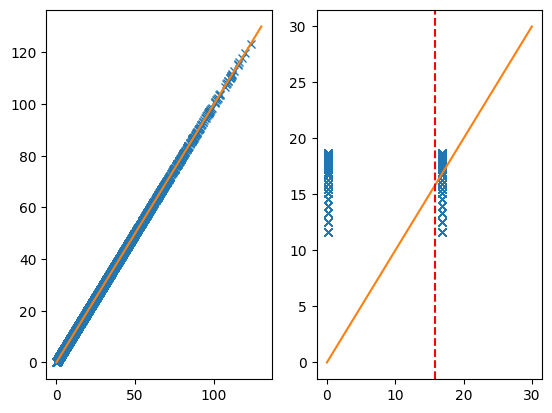

5.678431455228688
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.728  0.374E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.413E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.656  0.423E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.889  0.267E+00    32081    40.23  0.157   [Radiance 0.660 micron]
     5  -2.196  0.154E+00    32730    44.24  0.173   [Radiance 0.660 micron]
     6  -2.246  0.902E-01    34605    54.48  0.213   [Radiance 0.660 micron]
     7  -2.372  0.660E-01    37132    66.91  0.261   [Radiance 0.660 micron]
     8  -2.430  0.507E-01    40278    80.25  0.313   [Radiance 0.660 micron]
     9  -2.542  0.422E-01    43640    92.67  0.362   [Radiance 0.660 micron]
    10  -2.597  0.350E-01    48250   106.69  0.417   [Radiance 0.660 micron]
    11  -2.696  0.304E-01    52426   117.28  0.458   [Radiance 0.660 micron]
    12  -2.985  0.300E-01    52983   118.52  0.463   [Radianc

<Figure size 640x480 with 0 Axes>

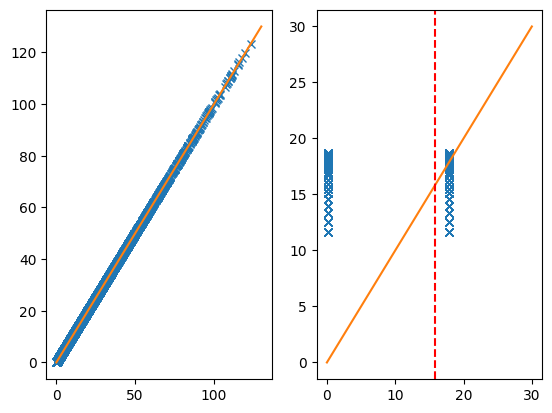

6.2990962506815915
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.373E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.412E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.656  0.422E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.890  0.267E+00    32081    40.23  0.157   [Radiance 0.660 micron]
     5  -2.198  0.154E+00    32730    44.24  0.173   [Radiance 0.660 micron]
     6  -2.247  0.899E-01    34591    54.41  0.213   [Radiance 0.660 micron]
     7  -2.373  0.659E-01    37120    66.84  0.261   [Radiance 0.660 micron]
     8  -2.431  0.505E-01    40243    80.12  0.313   [Radiance 0.660 micron]
     9  -2.542  0.421E-01    43619    92.60  0.362   [Radiance 0.660 micron]
    10  -2.599  0.350E-01    48169   106.48  0.416   [Radiance 0.660 micron]
    11  -2.697  0.303E-01    52345   117.07  0.457   [Radiance 0.660 micron]
    12  -2.994  0.300E-01    52816   118.12  0.461   [Radian

<Figure size 640x480 with 0 Axes>

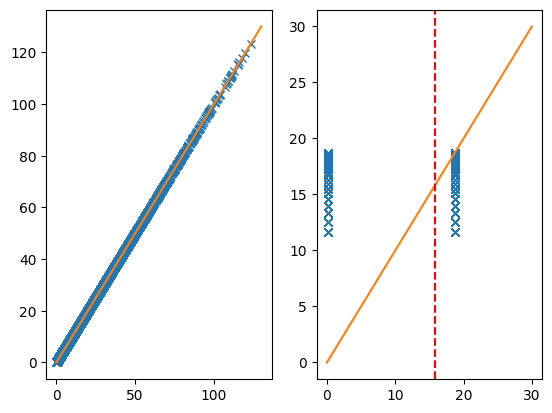

10.528360985934112
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.372E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.411E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.656  0.421E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.890  0.266E+00    32081    40.23  0.157   [Radiance 0.660 micron]
     5  -2.199  0.154E+00    32728    44.23  0.173   [Radiance 0.660 micron]
     6  -2.248  0.897E-01    34582    54.36  0.212   [Radiance 0.660 micron]
     7  -2.374  0.657E-01    37106    66.78  0.261   [Radiance 0.660 micron]
     8  -2.432  0.505E-01    40214    80.02  0.313   [Radiance 0.660 micron]
     9  -2.542  0.421E-01    43580    92.47  0.361   [Radiance 0.660 micron]
    10  -2.600  0.349E-01    48103   106.29  0.415   [Radiance 0.660 micron]
    11  -2.698  0.303E-01    52227   116.77  0.456   [Radiance 0.660 micron]
    12  -2.997  0.300E-01    52691   117.85  0.460   [Radian

<Figure size 640x480 with 0 Axes>

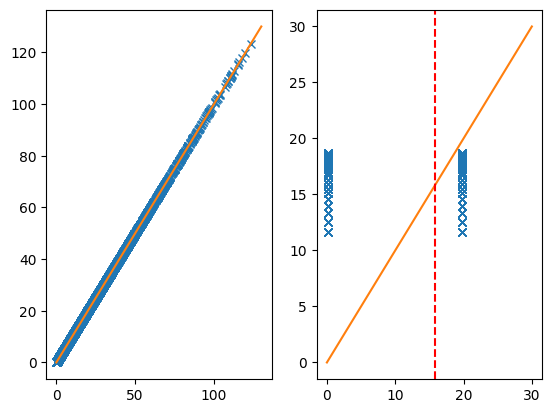

17.569777338163213


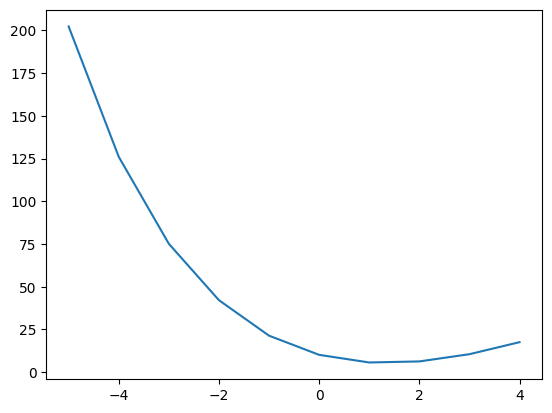

In [ ]:
solvers_reconstruct = at3d.containers.SolversDict()
def get_loss_uniform(reff_diff):
    # We are using the ground_truth rte_grid.
    grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, optical_properties
    )

    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        reff=(None, at3d.transforms.StateToGridUniform(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data*0 + solvers[0.66].medium['cloud'].reff.data.ravel().mean() + reff_diff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_diff
    return objective_function(x0)[0]
losses = []
for i in range(-5, 5):
    losses.append(get_loss_uniform(i))
    plot(None)
    print(losses[i+5])
py.plot(range(-5, 5),losses)

### Hide

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        28351     M =           10

At X0     28350 variables are exactly at the bounds

At iterate    0    f=  5.91438D+05    |proj g|=  1.25719D+01
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.650  0.219E+00    31968   203.00  0.793   [Radiance 0.660 micron]
     2  -1.284  0.228E+00    31968   203.00  0.793   [Radiance 0.660 micron]
     3  -1.822  0.226E+00    31968   203.00  0.793   [Radiance 0.660 micron]
     4  -2.191  0.150E+00    32354   203.64  0.795   [Radiance 0.660 micron]
     5  -2.804  0.835E-01    32862   204.29  0.798   [Radiance 0.660 micron]
     

<Figure size 640x480 with 0 Axes>

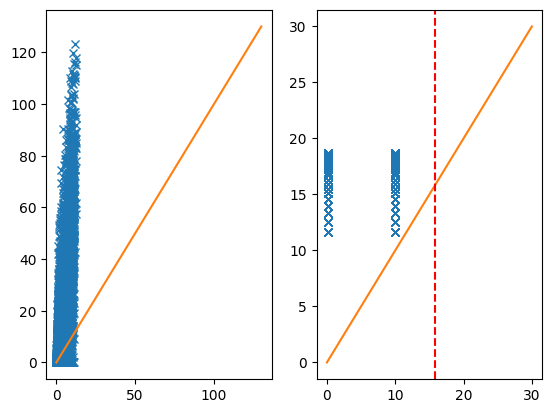

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.667  0.175E+00    31968   191.12  0.747   [Radiance 0.660 micron]
     2  -1.241  0.174E+00    31968   191.12  0.747   [Radiance 0.660 micron]
     3  -1.801  0.169E+00    31968   191.12  0.747   [Radiance 0.660 micron]
     4  -2.148  0.124E+00    32095   191.38  0.748   [Radiance 0.660 micron]
     5  -2.799  0.754E-01    32381   191.88  0.750   [Radiance 0.660 micron]
     6  -2.705  0.406E-01    33223   193.12  0.754   [Radiance 0.660 micron]
     7  -2.843  0.314E-01    34077   194.50  0.760   [Radiance 0.660 micron]
     8  -3.248  0.300E-01    34206   194.69  0.761   [Radiance 0.660 micron]
     9  -3.924  0.300E-01    34206   194.69  0.761   [Radiance 0.660 micron]
    10  -4.503  0.300E-01    34206   194.69  0.761   [Radiance 0.660 micron]
 ! Iterations:     10     Final Criterion:  0.000031   [Radiance 0.660 micron]

At iterate    2    f=  1.97320D+05    |proj g|=  4.46920D+00


<Figure size 640x480 with 0 Axes>

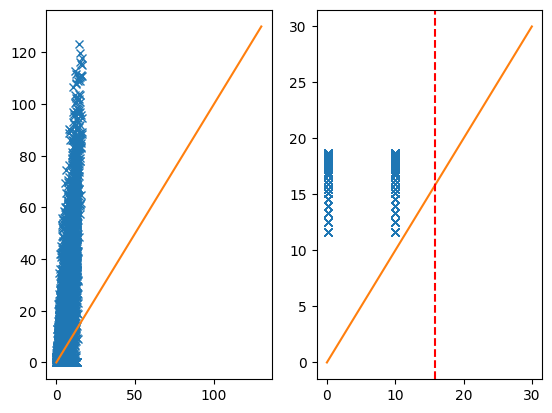

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.687  0.349E+00    31968   162.90  0.636   [Radiance 0.660 micron]
     2  -1.218  0.346E+00    31968   162.90  0.636   [Radiance 0.660 micron]
     3  -1.770  0.342E+00    31968   162.90  0.636   [Radiance 0.660 micron]
     4  -2.118  0.222E+00    32036   163.10  0.637   [Radiance 0.660 micron]
     5  -2.645  0.113E+00    32204   163.59  0.639   [Radiance 0.660 micron]
     6  -2.866  0.526E-01    32778   164.99  0.645   [Radiance 0.660 micron]
     7  -2.831  0.302E-01    33894   167.62  0.655   [Radiance 0.660 micron]
     8  -3.494  0.299E-01    33914   167.67  0.655   [Radiance 0.660 micron]
     9  -3.892  0.299E-01    33914   167.67  0.655   [Radiance 0.660 micron]
    10  -4.173  0.299E-01    33914   167.67  0.655   [Radiance 0.660 micron]
 ! Iterations:     10     Final Criterion:  0.000067   [Radiance 0.660 micron]

At iterate    3    f=  1.38478D+05    |proj g|=  4.01669D+00


<Figure size 640x480 with 0 Axes>

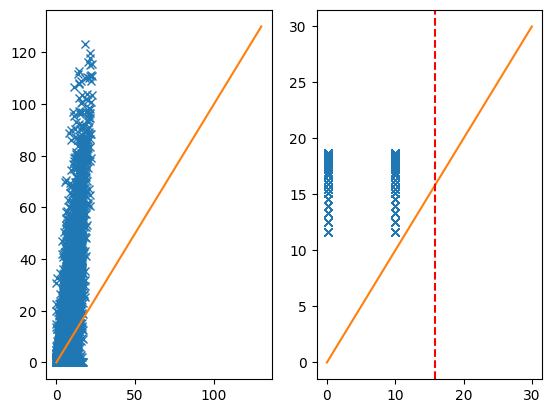

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.692  0.320E+00    31968   151.17  0.590   [Radiance 0.660 micron]
     2  -1.215  0.322E+00    31968   151.17  0.590   [Radiance 0.660 micron]
     3  -1.748  0.320E+00    31968   151.17  0.590   [Radiance 0.660 micron]
     4  -2.094  0.213E+00    32093   151.58  0.592   [Radiance 0.660 micron]
     5  -2.587  0.110E+00    32231   152.01  0.594   [Radiance 0.660 micron]
     6  -2.807  0.551E-01    32817   153.59  0.600   [Radiance 0.660 micron]
     7  -2.837  0.326E-01    33989   156.70  0.612   [Radiance 0.660 micron]
     8  -3.197  0.300E-01    34306   157.48  0.615   [Radiance 0.660 micron]
     9  -3.673  0.300E-01    34306   157.48  0.615   [Radiance 0.660 micron]
    10  -3.953  0.300E-01    34306   157.48  0.615   [Radiance 0.660 micron]
    11  -4.571  0.300E-01    34306   157.48  0.615   [Radiance 0.660 micron]
 ! Iterations:     11     Final Criterion:  0.000027   [Radiance 0.660 micron]


<Figure size 640x480 with 0 Axes>

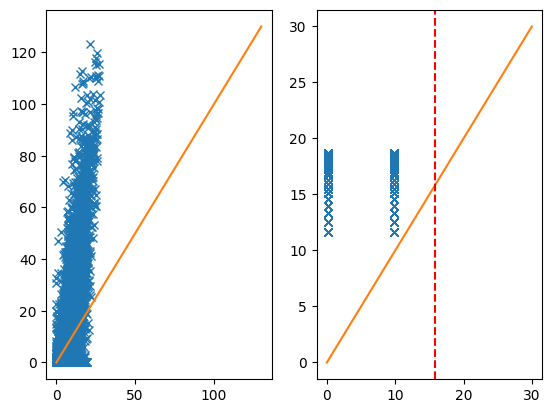

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.697  0.316E+00    31968   138.76  0.542   [Radiance 0.660 micron]
     2  -1.214  0.329E+00    31968   138.76  0.542   [Radiance 0.660 micron]
     3  -1.730  0.326E+00    31968   138.76  0.542   [Radiance 0.660 micron]
     4  -2.073  0.220E+00    32027   138.97  0.543   [Radiance 0.660 micron]
     5  -2.565  0.115E+00    32214   139.65  0.546   [Radiance 0.660 micron]
     6  -2.783  0.570E-01    32717   141.11  0.551   [Radiance 0.660 micron]
     7  -2.771  0.337E-01    34203   145.57  0.569   [Radiance 0.660 micron]
     8  -3.086  0.300E-01    34850   147.37  0.576   [Radiance 0.660 micron]
     9  -3.570  0.300E-01    34850   147.37  0.576   [Radiance 0.660 micron]
    10  -3.859  0.300E-01    34850   147.37  0.576   [Radiance 0.660 micron]
    11  -4.382  0.300E-01    34850   147.37  0.576   [Radiance 0.660 micron]
 ! Iterations:     11     Final Criterion:  0.000042   [Radiance 0.660 micron]


<Figure size 640x480 with 0 Axes>

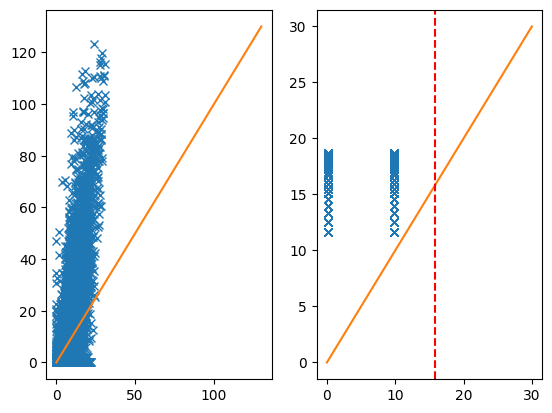

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.697  0.301E+00    31968   126.17  0.493   [Radiance 0.660 micron]
     2  -1.214  0.301E+00    31968   126.17  0.493   [Radiance 0.660 micron]
     3  -1.709  0.298E+00    31968   126.17  0.493   [Radiance 0.660 micron]
     4  -2.047  0.202E+00    31986   126.25  0.493   [Radiance 0.660 micron]
     5  -2.539  0.112E+00    32168   126.96  0.496   [Radiance 0.660 micron]
     6  -2.732  0.574E-01    32721   128.65  0.503   [Radiance 0.660 micron]
     7  -2.694  0.354E-01    34417   134.14  0.524   [Radiance 0.660 micron]
     8  -2.943  0.300E-01    35552   137.78  0.538   [Radiance 0.660 micron]
     9  -3.427  0.300E-01    35561   137.80  0.538   [Radiance 0.660 micron]
    10  -3.742  0.300E-01    35561   137.80  0.538   [Radiance 0.660 micron]
    11  -4.138  0.300E-01    35561   137.80  0.538   [Radiance 0.660 micron]
 ! Iterations:     11     Final Criterion:  0.000073   [Radiance 0.660 micron]


<Figure size 640x480 with 0 Axes>

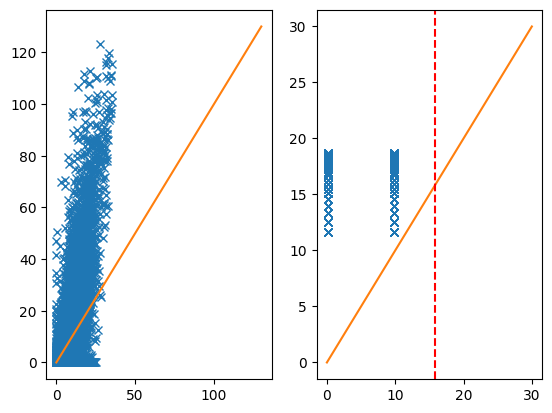

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.690  0.239E+00    31968   114.06  0.446   [Radiance 0.660 micron]
     2  -1.214  0.220E+00    31968   114.06  0.446   [Radiance 0.660 micron]
     3  -1.684  0.218E+00    31968   114.06  0.446   [Radiance 0.660 micron]
     4  -2.013  0.162E+00    32025   114.31  0.447   [Radiance 0.660 micron]
     5  -2.503  0.975E-01    32231   115.05  0.449   [Radiance 0.660 micron]
     6  -2.647  0.547E-01    33052   118.07  0.461   [Radiance 0.660 micron]
     7  -2.619  0.374E-01    34816   124.54  0.486   [Radiance 0.660 micron]
     8  -2.895  0.314E-01    36117   128.75  0.503   [Radiance 0.660 micron]
     9  -3.201  0.300E-01    36519   130.05  0.508   [Radiance 0.660 micron]
    10  -3.595  0.300E-01    36519   130.05  0.508   [Radiance 0.660 micron]
    11  -3.834  0.300E-01    36519   130.05  0.508   [Radiance 0.660 micron]
    12  -4.044  0.300E-01    36519   130.05  0.508   [Radiance 0.660 micron]
 !

<Figure size 640x480 with 0 Axes>

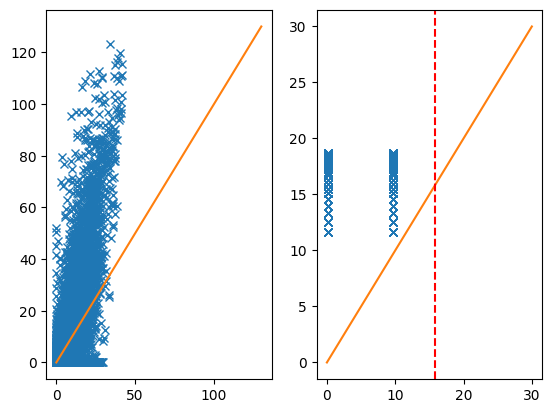

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.685  0.221E+00    31968   105.77  0.413   [Radiance 0.660 micron]
     2  -1.219  0.227E+00    31968   105.77  0.413   [Radiance 0.660 micron]
     3  -1.660  0.228E+00    31968   105.77  0.413   [Radiance 0.660 micron]
     4  -1.976  0.168E+00    32042   106.12  0.415   [Radiance 0.660 micron]
     5  -2.469  0.102E+00    32295   107.14  0.419   [Radiance 0.660 micron]
     6  -2.561  0.575E-01    33459   111.74  0.436   [Radiance 0.660 micron]
     7  -2.554  0.405E-01    35451   119.25  0.466   [Radiance 0.660 micron]
     8  -2.878  0.341E-01    36785   123.83  0.484   [Radiance 0.660 micron]
     9  -2.949  0.300E-01    38210   128.45  0.502   [Radiance 0.660 micron]
    10  -3.348  0.300E-01    38227   128.51  0.502   [Radiance 0.660 micron]
    11  -3.603  0.300E-01    38227   128.51  0.502   [Radiance 0.660 micron]
    12  -3.790  0.300E-01    38227   128.51  0.502   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

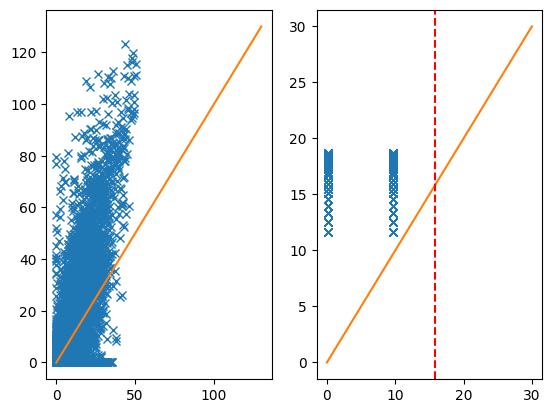

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.679  0.223E+00    31968   106.33  0.415   [Radiance 0.660 micron]
     2  -1.222  0.250E+00    31968   106.33  0.415   [Radiance 0.660 micron]
     3  -1.645  0.259E+00    31968   106.33  0.415   [Radiance 0.660 micron]
     4  -1.952  0.185E+00    32045   106.69  0.417   [Radiance 0.660 micron]
     5  -2.452  0.111E+00    32315   107.78  0.421   [Radiance 0.660 micron]
     6  -2.507  0.607E-01    33775   113.56  0.444   [Radiance 0.660 micron]
     7  -2.506  0.431E-01    35913   121.42  0.474   [Radiance 0.660 micron]
     8  -2.810  0.364E-01    37548   126.80  0.495   [Radiance 0.660 micron]
     9  -2.833  0.300E-01    40098   134.43  0.525   [Radiance 0.660 micron]
    10  -3.199  0.300E-01    40132   134.52  0.525   [Radiance 0.660 micron]
    11  -3.451  0.300E-01    40132   134.52  0.525   [Radiance 0.660 micron]
    12  -3.625  0.300E-01    40132   134.52  0.525   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

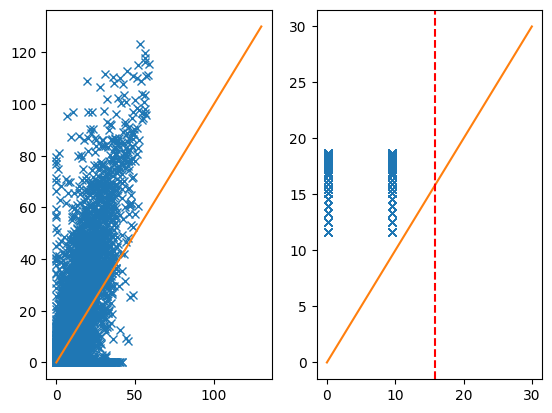

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.682  0.238E+00    31968   106.43  0.416   [Radiance 0.660 micron]
     2  -1.231  0.267E+00    31968   106.43  0.416   [Radiance 0.660 micron]
     3  -1.640  0.278E+00    31968   106.43  0.416   [Radiance 0.660 micron]
     4  -1.938  0.196E+00    32065   106.88  0.418   [Radiance 0.660 micron]
     5  -2.438  0.116E+00    32357   108.08  0.422   [Radiance 0.660 micron]
     6  -2.476  0.629E-01    34037   114.59  0.448   [Radiance 0.660 micron]
     7  -2.500  0.449E-01    36332   122.86  0.480   [Radiance 0.660 micron]
     8  -2.755  0.373E-01    38345   129.28  0.505   [Radiance 0.660 micron]
     9  -2.777  0.300E-01    41686   138.76  0.542   [Radiance 0.660 micron]
    10  -3.109  0.300E-01    41759   138.96  0.543   [Radiance 0.660 micron]
    11  -3.364  0.303E-01    41759   138.96  0.543   [Radiance 0.660 micron]
    12  -3.530  0.303E-01    41759   138.96  0.543   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

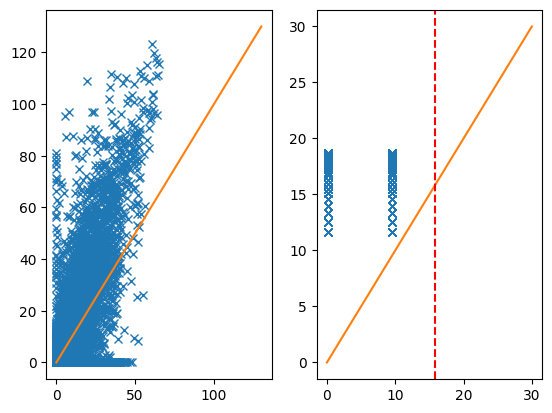

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.682  0.247E+00    31968   110.46  0.432   [Radiance 0.660 micron]
     2  -1.235  0.277E+00    31968   110.46  0.432   [Radiance 0.660 micron]
     3  -1.638  0.288E+00    31968   110.46  0.432   [Radiance 0.660 micron]
     4  -1.930  0.202E+00    32081   110.98  0.434   [Radiance 0.660 micron]
     5  -2.430  0.120E+00    32420   112.29  0.439   [Radiance 0.660 micron]
     6  -2.466  0.642E-01    34256   119.18  0.466   [Radiance 0.660 micron]
     7  -2.502  0.458E-01    36795   127.93  0.500   [Radiance 0.660 micron]
     8  -2.722  0.376E-01    39080   134.74  0.526   [Radiance 0.660 micron]
     9  -2.753  0.300E-01    42729   144.38  0.564   [Radiance 0.660 micron]
    10  -3.083  0.300E-01    42810   144.59  0.565   [Radiance 0.660 micron]
    11  -3.312  0.300E-01    42810   144.59  0.565   [Radiance 0.660 micron]
    12  -3.468  0.300E-01    42810   144.59  0.565   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

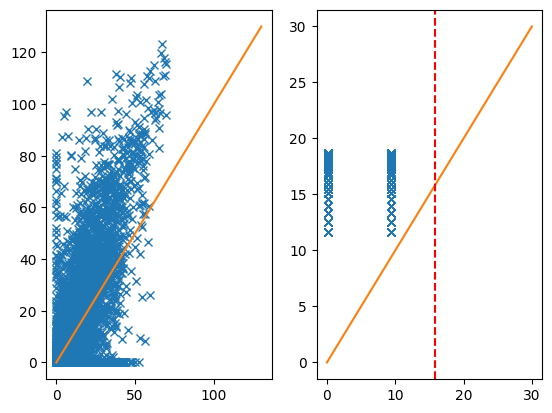

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.682  0.254E+00    31968   110.63  0.432   [Radiance 0.660 micron]
     2  -1.239  0.284E+00    31968   110.63  0.432   [Radiance 0.660 micron]
     3  -1.637  0.296E+00    31968   110.63  0.432   [Radiance 0.660 micron]
     4  -1.923  0.206E+00    32088   111.18  0.434   [Radiance 0.660 micron]
     5  -2.422  0.123E+00    32484   112.73  0.440   [Radiance 0.660 micron]
     6  -2.447  0.653E-01    34480   120.17  0.469   [Radiance 0.660 micron]
     7  -2.505  0.468E-01    37224   129.43  0.506   [Radiance 0.660 micron]
     8  -2.673  0.380E-01    39870   137.26  0.536   [Radiance 0.660 micron]
     9  -2.738  0.302E-01    43743   147.03  0.574   [Radiance 0.660 micron]
    10  -3.035  0.300E-01    43976   147.56  0.576   [Radiance 0.660 micron]
    11  -3.268  0.303E-01    43976   147.56  0.576   [Radiance 0.660 micron]
    12  -3.424  0.303E-01    43976   147.56  0.576   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

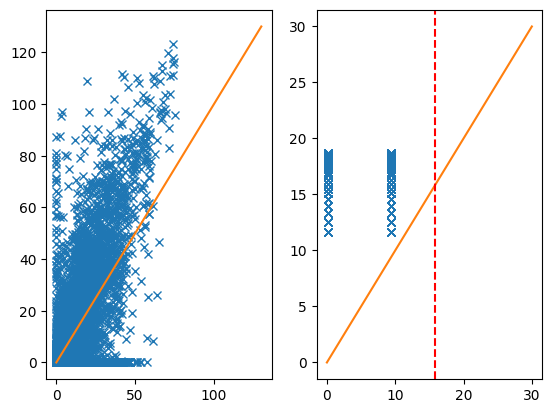

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.679  0.258E+00    31968   111.97  0.437   [Radiance 0.660 micron]
     2  -1.241  0.288E+00    31968   111.97  0.437   [Radiance 0.660 micron]
     3  -1.635  0.301E+00    31968   111.97  0.437   [Radiance 0.660 micron]
     4  -1.915  0.210E+00    32099   112.54  0.440   [Radiance 0.660 micron]
     5  -2.411  0.124E+00    32530   114.19  0.446   [Radiance 0.660 micron]
     6  -2.437  0.664E-01    34706   122.22  0.477   [Radiance 0.660 micron]
     7  -2.488  0.476E-01    37699   132.02  0.516   [Radiance 0.660 micron]
     8  -2.660  0.388E-01    40444   139.80  0.546   [Radiance 0.660 micron]
     9  -2.705  0.308E-01    44669   149.96  0.586   [Radiance 0.660 micron]
    10  -2.937  0.300E-01    45314   151.39  0.591   [Radiance 0.660 micron]
    11  -3.229  0.300E-01    45341   151.45  0.592   [Radiance 0.660 micron]
    12  -3.417  0.300E-01    45341   151.45  0.592   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

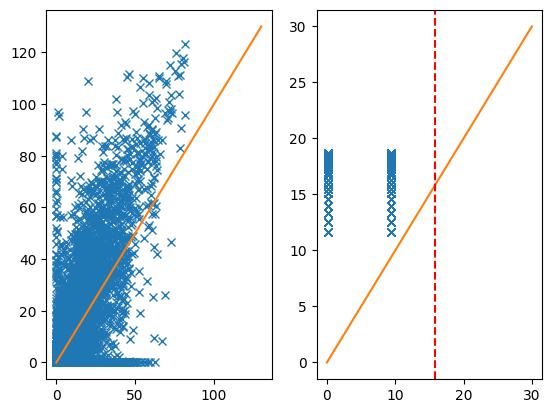

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.679  0.270E+00    31968   116.12  0.454   [Radiance 0.660 micron]
     2  -1.244  0.295E+00    31968   116.12  0.454   [Radiance 0.660 micron]
     3  -1.637  0.301E+00    31968   116.12  0.454   [Radiance 0.660 micron]
     4  -1.914  0.214E+00    32107   116.71  0.456   [Radiance 0.660 micron]
     5  -2.406  0.126E+00    32569   118.44  0.463   [Radiance 0.660 micron]
     6  -2.431  0.673E-01    34870   126.77  0.495   [Radiance 0.660 micron]
     7  -2.491  0.482E-01    38091   136.94  0.535   [Radiance 0.660 micron]
     8  -2.646  0.389E-01    41027   144.87  0.566   [Radiance 0.660 micron]
     9  -2.688  0.311E-01    45486   155.04  0.606   [Radiance 0.660 micron]
    10  -2.935  0.300E-01    46449   157.00  0.613   [Radiance 0.660 micron]
    11  -3.194  0.300E-01    46506   157.11  0.614   [Radiance 0.660 micron]
    12  -3.389  0.301E-01    46506   157.11  0.614   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

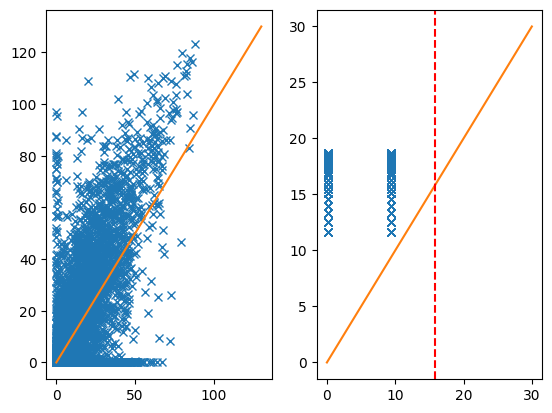

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.680  0.282E+00    31968   114.84  0.449   [Radiance 0.660 micron]
     2  -1.245  0.308E+00    31968   114.84  0.449   [Radiance 0.660 micron]
     3  -1.638  0.314E+00    31968   114.84  0.449   [Radiance 0.660 micron]
     4  -1.912  0.221E+00    32102   115.42  0.451   [Radiance 0.660 micron]
     5  -2.401  0.130E+00    32571   117.22  0.458   [Radiance 0.660 micron]
     6  -2.427  0.686E-01    35098   126.41  0.494   [Radiance 0.660 micron]
     7  -2.479  0.488E-01    38602   137.40  0.537   [Radiance 0.660 micron]
     8  -2.611  0.396E-01    41683   145.53  0.568   [Radiance 0.660 micron]
     9  -2.689  0.322E-01    45905   155.03  0.606   [Radiance 0.660 micron]
    10  -2.865  0.300E-01    47786   158.65  0.620   [Radiance 0.660 micron]
    11  -3.150  0.300E-01    47852   158.77  0.620   [Radiance 0.660 micron]
    12  -3.347  0.300E-01    47852   158.77  0.620   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

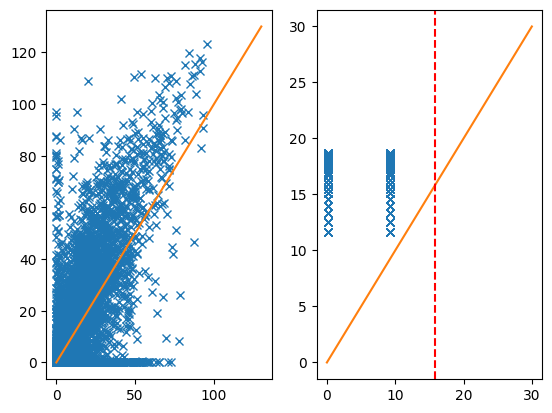

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.679  0.286E+00    31968   117.96  0.461   [Radiance 0.660 micron]
     2  -1.245  0.311E+00    31968   117.96  0.461   [Radiance 0.660 micron]
     3  -1.639  0.318E+00    31968   117.96  0.461   [Radiance 0.660 micron]
     4  -1.910  0.223E+00    32106   118.53  0.463   [Radiance 0.660 micron]
     5  -2.401  0.131E+00    32596   120.42  0.470   [Radiance 0.660 micron]
     6  -2.424  0.689E-01    35263   129.81  0.507   [Radiance 0.660 micron]
     7  -2.479  0.490E-01    38961   141.08  0.551   [Radiance 0.660 micron]
     8  -2.600  0.397E-01    42280   149.61  0.584   [Radiance 0.660 micron]
     9  -2.687  0.325E-01    46384   158.39  0.619   [Radiance 0.660 micron]
    10  -2.855  0.300E-01    48496   162.36  0.634   [Radiance 0.660 micron]
    11  -3.132  0.300E-01    48564   162.48  0.635   [Radiance 0.660 micron]
    12  -3.325  0.300E-01    48564   162.48  0.635   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

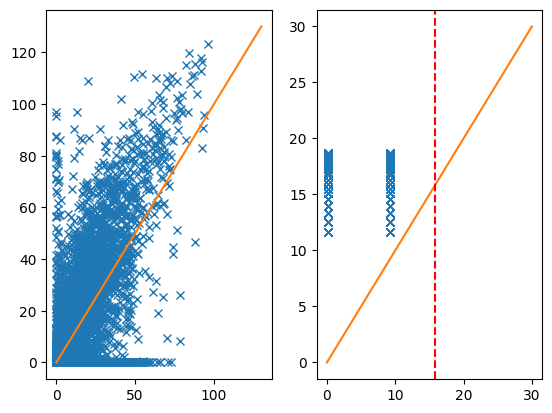

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.688  0.288E+00    31968   108.85  0.425   [Radiance 0.660 micron]
     2  -1.249  0.314E+00    31968   108.85  0.425   [Radiance 0.660 micron]
     3  -1.641  0.321E+00    31968   108.85  0.425   [Radiance 0.660 micron]
     4  -1.909  0.224E+00    32110   109.47  0.428   [Radiance 0.660 micron]
     5  -2.388  0.131E+00    32635   111.64  0.436   [Radiance 0.660 micron]
     6  -2.418  0.697E-01    35398   122.03  0.477   [Radiance 0.660 micron]
     7  -2.469  0.496E-01    39232   134.38  0.525   [Radiance 0.660 micron]
     8  -2.585  0.402E-01    42631   143.45  0.560   [Radiance 0.660 micron]
     9  -2.685  0.331E-01    46655   152.51  0.596   [Radiance 0.660 micron]
    10  -2.822  0.300E-01    49499   158.11  0.618   [Radiance 0.660 micron]
    11  -3.110  0.300E-01    49583   158.25  0.618   [Radiance 0.660 micron]
    12  -3.307  0.300E-01    49583   158.25  0.618   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

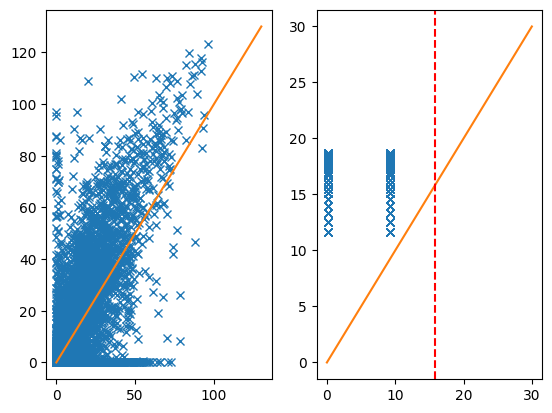

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.681  0.286E+00    31968   131.97  0.515   [Radiance 0.660 micron]
     2  -1.246  0.312E+00    31968   131.97  0.515   [Radiance 0.660 micron]
     3  -1.640  0.319E+00    31968   131.97  0.515   [Radiance 0.660 micron]
     4  -1.910  0.224E+00    32115   132.53  0.518   [Radiance 0.660 micron]
     5  -2.398  0.131E+00    32616   134.28  0.525   [Radiance 0.660 micron]
     6  -2.422  0.691E-01    35313   142.89  0.558   [Radiance 0.660 micron]
     7  -2.487  0.492E-01    39057   153.18  0.598   [Radiance 0.660 micron]
     8  -2.599  0.395E-01    42544   161.15  0.629   [Radiance 0.660 micron]
     9  -2.694  0.325E-01    46643   168.96  0.660   [Radiance 0.660 micron]
    10  -2.838  0.300E-01    48820   172.59  0.674   [Radiance 0.660 micron]
    11  -3.131  0.300E-01    48887   172.69  0.675   [Radiance 0.660 micron]
    12  -3.327  0.300E-01    48887   172.69  0.675   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

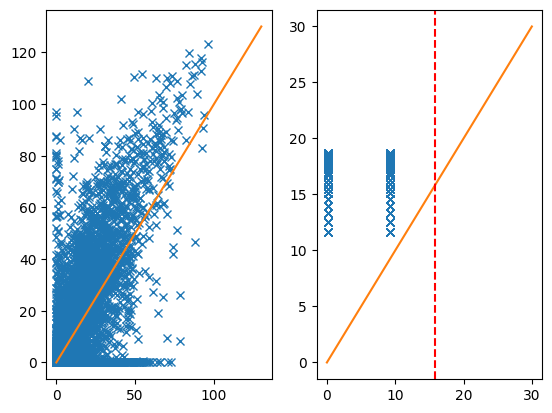

  ys=-2.661E-05  -gs= 5.385E-02 BFGS update SKIPPED
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.681  0.286E+00    31968   131.53  0.514   [Radiance 0.660 micron]
     2  -1.246  0.312E+00    31968   131.53  0.514   [Radiance 0.660 micron]
     3  -1.640  0.319E+00    31968   131.53  0.514   [Radiance 0.660 micron]
     4  -1.910  0.224E+00    32115   132.10  0.516   [Radiance 0.660 micron]
     5  -2.398  0.131E+00    32616   133.85  0.523   [Radiance 0.660 micron]
     6  -2.422  0.691E-01    35313   142.50  0.557   [Radiance 0.660 micron]
     7  -2.486  0.492E-01    39057   152.82  0.597   [Radiance 0.660 micron]
     8  -2.599  0.395E-01    42541   160.81  0.628   [Radiance 0.660 micron]
     9  -2.694  0.325E-01    46637   168.65  0.659   [Radiance 0.660 micron]
    10  -2.838  0.300E-01    48815   172.31  0.673   [Radiance 0.660 micron]
    11  -3.130  0.300E-01    48882   172.42  0.674   [Radiance 0.660 micron]
    12  -3.327  0.300E-01  

<Figure size 640x480 with 0 Axes>

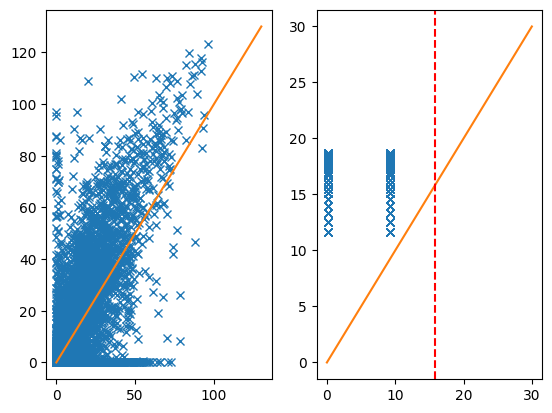

  ys=-2.069E-05  -gs= 4.377E-02 BFGS update SKIPPED
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.681  0.286E+00    31968   131.48  0.514   [Radiance 0.660 micron]
     2  -1.246  0.312E+00    31968   131.48  0.514   [Radiance 0.660 micron]
     3  -1.640  0.319E+00    31968   131.48  0.514   [Radiance 0.660 micron]
     4  -1.910  0.224E+00    32115   132.05  0.516   [Radiance 0.660 micron]
     5  -2.398  0.131E+00    32616   133.80  0.523   [Radiance 0.660 micron]
     6  -2.422  0.691E-01    35313   142.46  0.556   [Radiance 0.660 micron]
     7  -2.486  0.492E-01    39057   152.78  0.597   [Radiance 0.660 micron]
     8  -2.599  0.395E-01    42541   160.78  0.628   [Radiance 0.660 micron]
     9  -2.694  0.325E-01    46637   168.62  0.659   [Radiance 0.660 micron]
    10  -2.838  0.300E-01    48817   172.29  0.673   [Radiance 0.660 micron]
    11  -3.130  0.300E-01    48884   172.39  0.673   [Radiance 0.660 micron]
    12  -3.327  0.300E-01  

<Figure size 640x480 with 0 Axes>

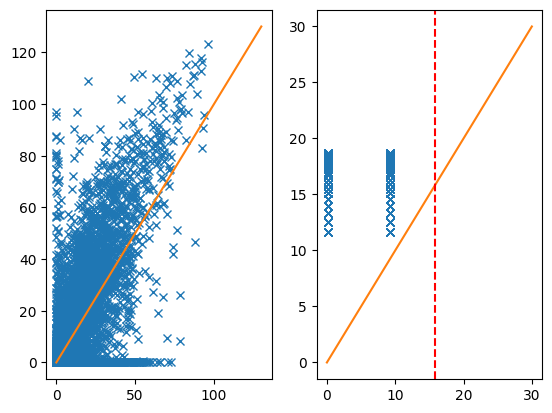


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351     20     61  23031     2 12316   3.005D+00   1.296D+04
  F =   12961.336002276501     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [9]:
solvers_reconstruct = at3d.containers.SolversDict()
# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, optical_properties
)

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e9)
sensors.add_uncertainty_model('MSPI', uncertainty)

# UnknownScatterers is a container for all of the unknown variables.
# Each unknown_scatterer also records the transforms from the abstract state vector
# to the gridded data in physical coordinates.
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(grid_to_optical_properties,
    density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
    reff=(None, at3d.transforms.StateToGridUniform(mask=carved_volume.mask.data)))
)
# now we form state_gen which updates the solvers with an input_state.

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                        unknown_scatterers, surfaces,
                                        numerical_parameters, sources, background_optical_scatterers,
                                        num_stokes)
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()
# transform initial physical state to abstract state. 
initial_gridded_extinction = solvers[0.66].medium['cloud'].density.data*0
initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data*0 + 10
initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
            state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
    state_gen.project_gradient_to_state,
        parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    uncertainty_kwargs={'add_noise': False},
    min_bounds=min_bounds, max_bounds=max_bounds)
optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-8})
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 20
result = optimizer.minimize(x0)

In [8]:
final_state = state_gen.get_state()
import warnings
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 25
result = optimizer.minimize(final_state)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.682  0.238E+00    31968   106.43  0.416   [Radiance 0.660 micron]
     2  -1.231  0.267E+00    31968   106.43  0.416   [Radiance 0.660 micron]
     3  -1.640  0.278E+00    31968   106.43  0.416   [Radiance 0.660 micron]
     4  -1.938  0.196E+00    32065   106.88  0.418   [Radiance 0.660 micron]
     5  -2.438  0.116E+00    32357   108.08  0.422   [Radiance 0.660 micron]
     6  -2.476  0.629E-01    34037   114.59  0.448   [Radiance 0.660 micron]
     7  -2.500  0.449E-01    36332   122.86  0.480   [Radiance 0.660 micron]
     8  -2.755  0.373E-01    38345   129.28  0.505   [Radiance 0.660 micron]
     9  -2.777  0.300E-01    41686   138.76  0.542   [Radiance 0.660 micron]
    10  -3.109  0.300E-01    41759   138.96  0.543   [Radiance 0.660 micron]
    11  -3.364  0.303E-01    41759   138.96  0.543   [Radiance 0.660 micron]
    12  -3.530  0.303E-01    41759   138.96  0.543   [Radiance 0.660 micron]
  


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1     11   1050     0 14125   1.791D+00   2.318D+04
  F =   23178.164605108916     

ABNORMAL_TERMINATION_IN_LNSRCH                              


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.322E+00    31968    99.71  0.389   [Radiance 0.660 micron]
     2  -1.285  0.347E+00    31968    99.71  0.389   [Radiance 0.660 micron]
     3  -1.679  0.356E+00    31968    99.71  0.389   [Radiance 0.660 micron]
     4  -1.956  0.229E+00    32111   100.36  0.392   [Radiance 0.660 micron]
     5  -2.396  0.131E+00    32545   102.19  0.399   [Radiance 0.660 micron]
     6  -2.425  0.695E-01    35052   112.12  0.438   [Radiance 0.660 micron]
     7  -2.481  0.494E-01    38126   122.89  0.480   [Radiance 0.660 micron]
     8  -2.596  0.398E-01    41084   131.77  0.515   [Radiance 0.660 micron]
     9  -2.682  0.326E-01    44582   140.72  0.550   [Radiance 0.660 micron]
    10  -2.839  0.300E-01    46659   145.41  0.568   [Radiance 0.660 micron]
    11  -3.113  0.300E-01    46751   145.58  0.569   [Radiance 0.660 micron]
    12  -3.304  0.300E-01    46751   145.58  0.569   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

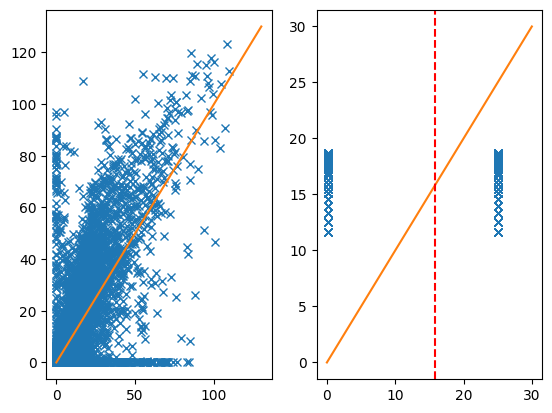

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.320E+00    31968    90.24  0.352   [Radiance 0.660 micron]
     2  -1.281  0.353E+00    31968    90.24  0.352   [Radiance 0.660 micron]
     3  -1.673  0.362E+00    31968    90.24  0.352   [Radiance 0.660 micron]
     4  -1.951  0.235E+00    32101    90.88  0.355   [Radiance 0.660 micron]
     5  -2.380  0.134E+00    32548    92.88  0.363   [Radiance 0.660 micron]
     6  -2.412  0.711E-01    34956   102.99  0.402   [Radiance 0.660 micron]
     7  -2.467  0.505E-01    37994   114.39  0.447   [Radiance 0.660 micron]
     8  -2.589  0.407E-01    40881   123.56  0.483   [Radiance 0.660 micron]
     9  -2.675  0.331E-01    44432   133.27  0.521   [Radiance 0.660 micron]
    10  -2.803  0.300E-01    46931   139.18  0.544   [Radiance 0.660 micron]
    11  -3.094  0.300E-01    47010   139.30  0.544   [Radiance 0.660 micron]
    12  -3.292  0.301E-01    47010   139.30  0.544   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

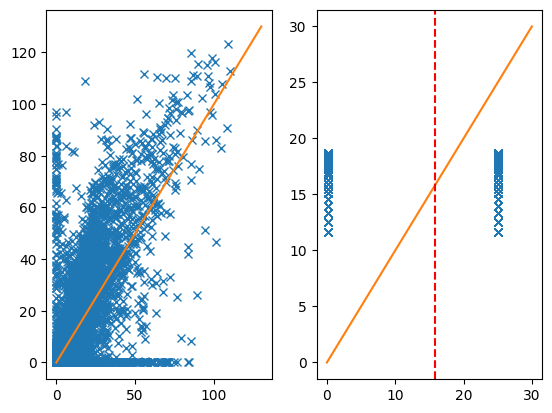

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.723  0.326E+00    31968    98.37  0.384   [Radiance 0.660 micron]
     2  -1.280  0.362E+00    31968    98.37  0.384   [Radiance 0.660 micron]
     3  -1.674  0.372E+00    31968    98.37  0.384   [Radiance 0.660 micron]
     4  -1.951  0.239E+00    32100    98.97  0.387   [Radiance 0.660 micron]
     5  -2.383  0.136E+00    32549   100.89  0.394   [Radiance 0.660 micron]
     6  -2.408  0.715E-01    34999   110.58  0.432   [Radiance 0.660 micron]
     7  -2.455  0.509E-01    38119   121.60  0.475   [Radiance 0.660 micron]
     8  -2.598  0.413E-01    40846   129.91  0.507   [Radiance 0.660 micron]
     9  -2.671  0.331E-01    44803   140.12  0.547   [Radiance 0.660 micron]
    10  -2.807  0.300E-01    47336   145.79  0.569   [Radiance 0.660 micron]
    11  -3.090  0.300E-01    47428   145.96  0.570   [Radiance 0.660 micron]
    12  -3.292  0.300E-01    47428   145.96  0.570   [Radiance 0.660 micron]
  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.723  0.320E+00    31968   108.43  0.424   [Radiance 0.660 micron]
     2  -1.282  0.354E+00    31968   108.43  0.424   [Radiance 0.660 micron]
     3  -1.677  0.364E+00    31968   108.43  0.424   [Radiance 0.660 micron]
     4  -1.955  0.236E+00    32101   109.00  0.426   [Radiance 0.660 micron]
     5  -2.385  0.133E+00    32552   110.78  0.433   [Radiance 0.660 micron]
     6  -2.415  0.707E-01    34990   119.84  0.468   [Radiance 0.660 micron]
     7  -2.469  0.503E-01    38069   130.08  0.508   [Radiance 0.660 micron]
     8  -2.597  0.406E-01    40977   138.32  0.540   [Radiance 0.660 micron]
     9  -2.679  0.329E-01    44643   147.20  0.575   [Radiance 0.660 micron]
    10  -2.808  0.300E-01    47017   152.18  0.594   [Radiance 0.660 micron]
    11  -3.098  0.300E-01    47098   152.29  0.595   [Radiance 0.660 micron]
    12  -3.298  0.301E-01    47098   152.29  0.595   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

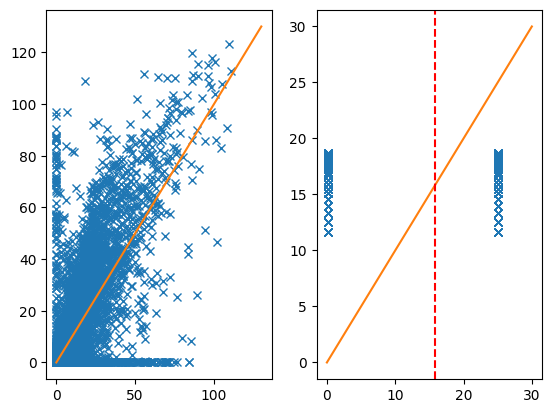

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.724  0.323E+00    31968    93.12  0.364   [Radiance 0.660 micron]
     2  -1.281  0.359E+00    31968    93.12  0.364   [Radiance 0.660 micron]
     3  -1.674  0.369E+00    31968    93.12  0.364   [Radiance 0.660 micron]
     4  -1.951  0.239E+00    32098    93.74  0.366   [Radiance 0.660 micron]
     5  -2.380  0.135E+00    32544    95.73  0.374   [Radiance 0.660 micron]
     6  -2.411  0.716E-01    34952   105.59  0.412   [Radiance 0.660 micron]
     7  -2.459  0.507E-01    38036   116.97  0.457   [Radiance 0.660 micron]
     8  -2.595  0.411E-01    40819   125.73  0.491   [Radiance 0.660 micron]
     9  -2.668  0.331E-01    44614   135.86  0.531   [Radiance 0.660 micron]
    10  -2.807  0.300E-01    47132   141.69  0.553   [Radiance 0.660 micron]
    11  -3.089  0.300E-01    47213   141.82  0.554   [Radiance 0.660 micron]
    12  -3.292  0.300E-01    47213   141.82  0.554   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

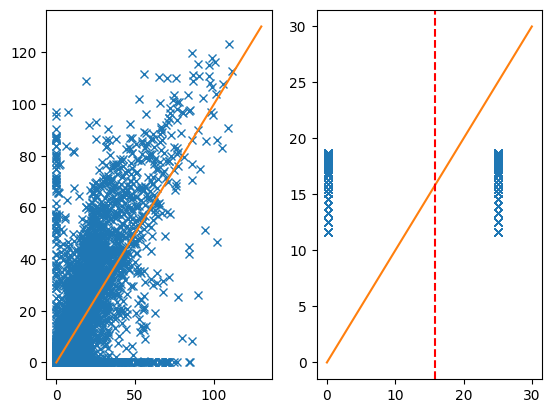

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.719  0.335E+00    31968   101.86  0.398   [Radiance 0.660 micron]
     2  -1.281  0.371E+00    31968   101.86  0.398   [Radiance 0.660 micron]
     3  -1.675  0.381E+00    31968   101.86  0.398   [Radiance 0.660 micron]
     4  -1.952  0.245E+00    32081   102.37  0.400   [Radiance 0.660 micron]
     5  -2.390  0.138E+00    32530   104.25  0.407   [Radiance 0.660 micron]
     6  -2.409  0.717E-01    35000   113.86  0.445   [Radiance 0.660 micron]
     7  -2.453  0.510E-01    38126   124.62  0.487   [Radiance 0.660 micron]
     8  -2.597  0.414E-01    40914   132.95  0.519   [Radiance 0.660 micron]
     9  -2.667  0.332E-01    44850   142.80  0.558   [Radiance 0.660 micron]
    10  -2.817  0.300E-01    47416   148.36  0.580   [Radiance 0.660 micron]
    11  -3.077  0.300E-01    47507   148.52  0.580   [Radiance 0.660 micron]
    12  -3.294  0.300E-01    47507   148.52  0.580   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

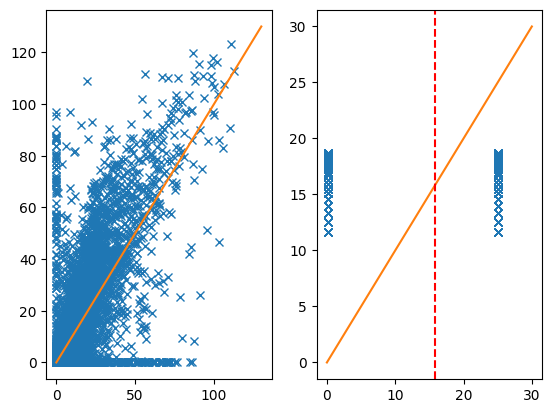

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.716  0.361E+00    31968    98.29  0.384   [Radiance 0.660 micron]
     2  -1.278  0.398E+00    31968    98.29  0.384   [Radiance 0.660 micron]
     3  -1.671  0.409E+00    31968    98.29  0.384   [Radiance 0.660 micron]
     4  -1.947  0.260E+00    32062    98.74  0.386   [Radiance 0.660 micron]
     5  -2.382  0.145E+00    32507   100.63  0.393   [Radiance 0.660 micron]
     6  -2.398  0.742E-01    34922   110.23  0.431   [Radiance 0.660 micron]
     7  -2.436  0.525E-01    38202   121.87  0.476   [Radiance 0.660 micron]
     8  -2.584  0.427E-01    40940   129.92  0.508   [Radiance 0.660 micron]
     9  -2.645  0.340E-01    45112   140.59  0.549   [Radiance 0.660 micron]
    10  -2.764  0.300E-01    48210   147.28  0.575   [Radiance 0.660 micron]
    11  -3.061  0.300E-01    48309   147.45  0.576   [Radiance 0.660 micron]
    12  -3.264  0.304E-01    48309   147.45  0.576   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

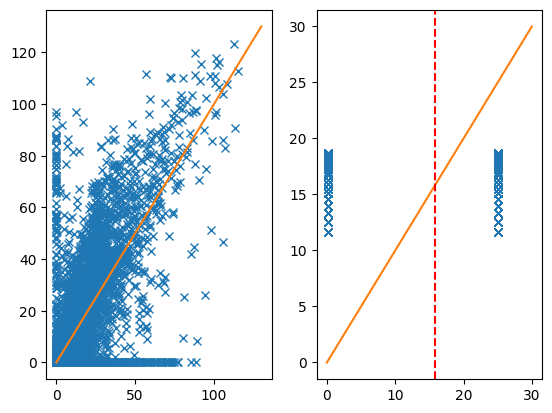

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.713  0.378E+00    31968    94.73  0.370   [Radiance 0.660 micron]
     2  -1.273  0.415E+00    31968    94.73  0.370   [Radiance 0.660 micron]
     3  -1.666  0.427E+00    31968    94.73  0.370   [Radiance 0.660 micron]
     4  -1.940  0.274E+00    32055    95.16  0.372   [Radiance 0.660 micron]
     5  -2.368  0.150E+00    32521    97.19  0.380   [Radiance 0.660 micron]
     6  -2.381  0.765E-01    34930   106.95  0.418   [Radiance 0.660 micron]
     7  -2.422  0.542E-01    38186   118.67  0.464   [Radiance 0.660 micron]
     8  -2.563  0.440E-01    40927   127.02  0.496   [Radiance 0.660 micron]
     9  -2.621  0.351E-01    45193   138.08  0.539   [Radiance 0.660 micron]
    10  -2.721  0.300E-01    49257   146.85  0.574   [Radiance 0.660 micron]
    11  -3.028  0.300E-01    49384   147.08  0.575   [Radiance 0.660 micron]
    12  -3.245  0.301E-01    49384   147.08  0.575   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

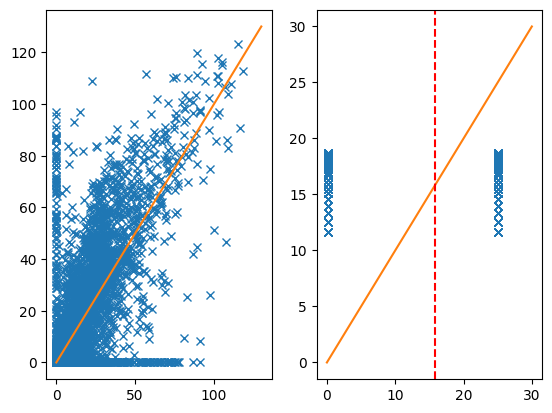

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.712  0.387E+00    31968    94.25  0.368   [Radiance 0.660 micron]
     2  -1.271  0.423E+00    31968    94.25  0.368   [Radiance 0.660 micron]
     3  -1.663  0.436E+00    31968    94.25  0.368   [Radiance 0.660 micron]
     4  -1.937  0.277E+00    32062    94.71  0.370   [Radiance 0.660 micron]
     5  -2.357  0.152E+00    32524    96.72  0.378   [Radiance 0.660 micron]
     6  -2.371  0.781E-01    34946   106.52  0.416   [Radiance 0.660 micron]
     7  -2.414  0.552E-01    38219   118.27  0.462   [Radiance 0.660 micron]
     8  -2.549  0.448E-01    40957   126.62  0.495   [Radiance 0.660 micron]
     9  -2.612  0.358E-01    45297   137.86  0.539   [Radiance 0.660 micron]
    10  -2.698  0.303E-01    49741   147.38  0.576   [Radiance 0.660 micron]
    11  -2.983  0.300E-01    50143   148.15  0.579   [Radiance 0.660 micron]
    12  -3.213  0.300E-01    50180   148.21  0.579   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

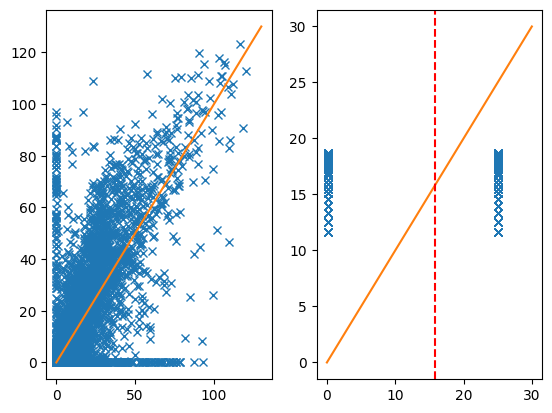

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.711  0.391E+00    31968    92.31  0.361   [Radiance 0.660 micron]
     2  -1.269  0.428E+00    31968    92.31  0.361   [Radiance 0.660 micron]
     3  -1.659  0.441E+00    31968    92.31  0.361   [Radiance 0.660 micron]
     4  -1.932  0.279E+00    32062    92.78  0.362   [Radiance 0.660 micron]
     5  -2.350  0.154E+00    32511    94.75  0.370   [Radiance 0.660 micron]
     6  -2.365  0.790E-01    34940   104.77  0.409   [Radiance 0.660 micron]
     7  -2.406  0.559E-01    38149   116.41  0.455   [Radiance 0.660 micron]
     8  -2.539  0.454E-01    40989   125.24  0.489   [Radiance 0.660 micron]
     9  -2.608  0.364E-01    45278   136.52  0.533   [Radiance 0.660 micron]
    10  -2.688  0.307E-01    49733   146.25  0.571   [Radiance 0.660 micron]
    11  -2.942  0.300E-01    50568   147.85  0.578   [Radiance 0.660 micron]
    12  -3.187  0.300E-01    50612   147.91  0.578   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

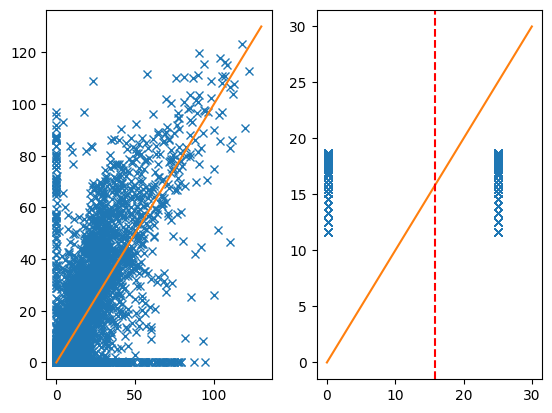

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.710  0.393E+00    31968    88.53  0.346   [Radiance 0.660 micron]
     2  -1.268  0.430E+00    31968    88.53  0.346   [Radiance 0.660 micron]
     3  -1.656  0.443E+00    31968    88.53  0.346   [Radiance 0.660 micron]
     4  -1.929  0.285E+00    32060    89.00  0.348   [Radiance 0.660 micron]
     5  -2.345  0.155E+00    32518    91.02  0.356   [Radiance 0.660 micron]
     6  -2.357  0.798E-01    34946   101.31  0.396   [Radiance 0.660 micron]
     7  -2.396  0.566E-01    38165   113.33  0.443   [Radiance 0.660 micron]
     8  -2.538  0.460E-01    40983   122.25  0.478   [Radiance 0.660 micron]
     9  -2.593  0.367E-01    45465   134.27  0.524   [Radiance 0.660 micron]
    10  -2.690  0.312E-01    49701   143.64  0.561   [Radiance 0.660 micron]
    11  -2.897  0.300E-01    50944   146.08  0.571   [Radiance 0.660 micron]
    12  -3.163  0.300E-01    51020   146.21  0.571   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

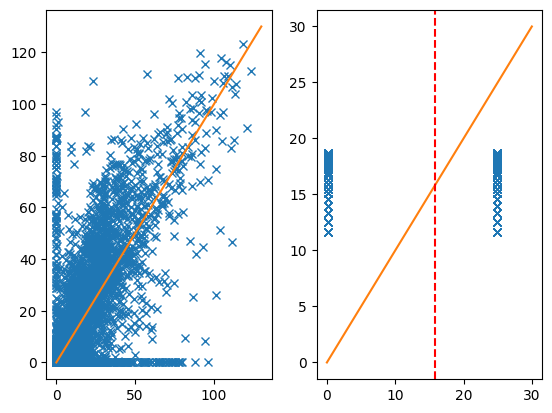

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.709  0.395E+00    31968    86.90  0.339   [Radiance 0.660 micron]
     2  -1.269  0.431E+00    31968    86.90  0.339   [Radiance 0.660 micron]
     3  -1.655  0.445E+00    31968    86.90  0.339   [Radiance 0.660 micron]
     4  -1.926  0.285E+00    32064    87.40  0.341   [Radiance 0.660 micron]
     5  -2.337  0.156E+00    32512    89.45  0.349   [Radiance 0.660 micron]
     6  -2.347  0.806E-01    35013   100.14  0.391   [Radiance 0.660 micron]
     7  -2.392  0.573E-01    38186   112.20  0.438   [Radiance 0.660 micron]
     8  -2.531  0.465E-01    41062   121.40  0.474   [Radiance 0.660 micron]
     9  -2.582  0.371E-01    45632   133.72  0.522   [Radiance 0.660 micron]
    10  -2.692  0.317E-01    49761   142.95  0.558   [Radiance 0.660 micron]
    11  -2.865  0.300E-01    51590   146.57  0.573   [Radiance 0.660 micron]
    12  -3.137  0.300E-01    51676   146.72  0.573   [Radiance 0.660 micron]
  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.709  0.393E+00    31968    95.85  0.374   [Radiance 0.660 micron]
     2  -1.269  0.430E+00    31968    95.85  0.374   [Radiance 0.660 micron]
     3  -1.657  0.443E+00    31968    95.85  0.374   [Radiance 0.660 micron]
     4  -1.929  0.285E+00    32060    96.31  0.376   [Radiance 0.660 micron]
     5  -2.346  0.155E+00    32517    98.28  0.384   [Radiance 0.660 micron]
     6  -2.356  0.796E-01    34966   108.22  0.423   [Radiance 0.660 micron]
     7  -2.399  0.566E-01    38154   119.68  0.467   [Radiance 0.660 micron]
     8  -2.537  0.459E-01    41019   128.44  0.502   [Radiance 0.660 micron]
     9  -2.595  0.367E-01    45490   139.93  0.547   [Radiance 0.660 micron]
    10  -2.689  0.311E-01    49728   148.92  0.582   [Radiance 0.660 micron]
    11  -2.903  0.300E-01    50989   151.24  0.591   [Radiance 0.660 micron]
    12  -3.162  0.300E-01    51053   151.35  0.591   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

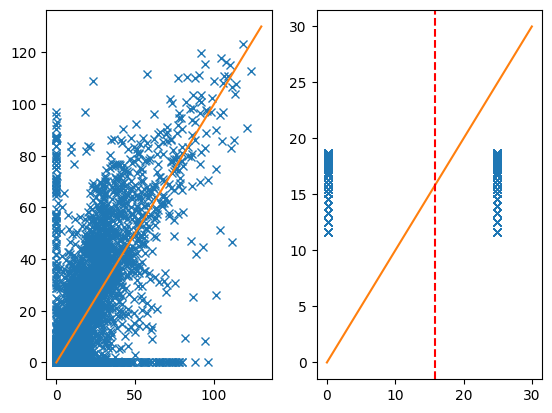

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.717  0.393E+00    31968    79.77  0.312   [Radiance 0.660 micron]
     2  -1.274  0.430E+00    31968    79.77  0.312   [Radiance 0.660 micron]
     3  -1.657  0.443E+00    31968    79.77  0.312   [Radiance 0.660 micron]
     4  -1.929  0.282E+00    32066    80.30  0.314   [Radiance 0.660 micron]
     5  -2.337  0.155E+00    32519    82.43  0.322   [Radiance 0.660 micron]
     6  -2.353  0.803E-01    34920    93.17  0.364   [Radiance 0.660 micron]
     7  -2.399  0.570E-01    38081   105.70  0.413   [Radiance 0.660 micron]
     8  -2.535  0.461E-01    40992   115.44  0.451   [Radiance 0.660 micron]
     9  -2.591  0.368E-01    45421   127.95  0.500   [Radiance 0.660 micron]
    10  -2.687  0.313E-01    49596   137.83  0.538   [Radiance 0.660 micron]
    11  -2.895  0.300E-01    50959   140.66  0.549   [Radiance 0.660 micron]
    12  -3.156  0.300E-01    51034   140.79  0.550   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

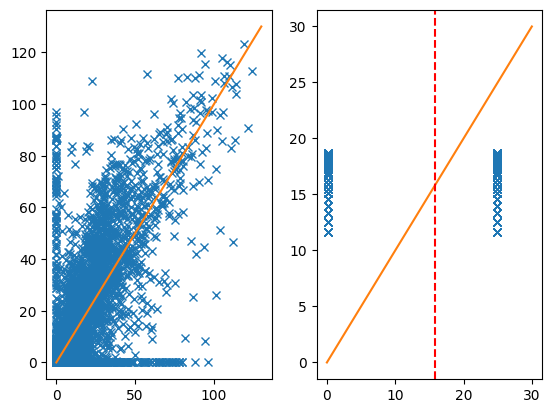

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.716  0.394E+00    31968    87.87  0.343   [Radiance 0.660 micron]
     2  -1.277  0.430E+00    31968    87.87  0.343   [Radiance 0.660 micron]
     3  -1.660  0.443E+00    31968    87.87  0.343   [Radiance 0.660 micron]
     4  -1.931  0.280E+00    32066    88.38  0.345   [Radiance 0.660 micron]
     5  -2.340  0.154E+00    32520    90.44  0.353   [Radiance 0.660 micron]
     6  -2.352  0.799E-01    34993   100.97  0.394   [Radiance 0.660 micron]
     7  -2.400  0.569E-01    38168   112.97  0.441   [Radiance 0.660 micron]
     8  -2.537  0.460E-01    41029   122.17  0.477   [Radiance 0.660 micron]
     9  -2.589  0.367E-01    45565   134.28  0.525   [Radiance 0.660 micron]
    10  -2.696  0.313E-01    49713   143.62  0.561   [Radiance 0.660 micron]
    11  -2.905  0.300E-01    51050   146.31  0.572   [Radiance 0.660 micron]
    12  -3.171  0.300E-01    51120   146.43  0.572   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

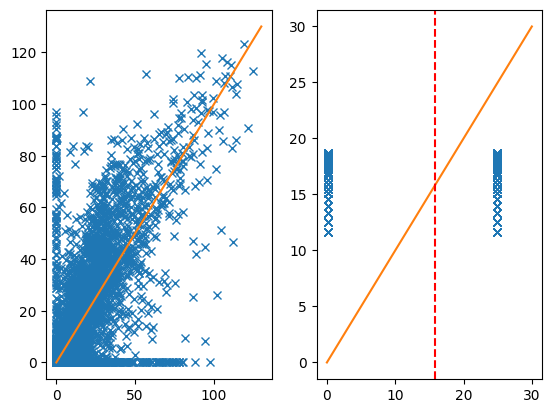

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.722  0.395E+00    31968    90.33  0.353   [Radiance 0.660 micron]
     2  -1.286  0.431E+00    31968    90.33  0.353   [Radiance 0.660 micron]
     3  -1.668  0.444E+00    31968    90.33  0.353   [Radiance 0.660 micron]
     4  -1.938  0.279E+00    32072    90.86  0.355   [Radiance 0.660 micron]
     5  -2.342  0.153E+00    32553    92.96  0.363   [Radiance 0.660 micron]
     6  -2.353  0.794E-01    35104   103.64  0.405   [Radiance 0.660 micron]
     7  -2.406  0.566E-01    38240   115.30  0.450   [Radiance 0.660 micron]
     8  -2.538  0.456E-01    41310   124.85  0.488   [Radiance 0.660 micron]
     9  -2.592  0.365E-01    45799   136.53  0.533   [Radiance 0.660 micron]
    10  -2.701  0.312E-01    49988   145.73  0.569   [Radiance 0.660 micron]
    11  -2.899  0.300E-01    51119   147.92  0.578   [Radiance 0.660 micron]
    12  -3.169  0.300E-01    51162   147.99  0.578   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

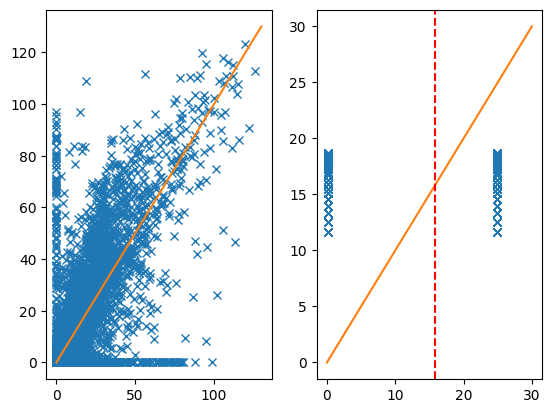

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.397E+00    31968    94.56  0.369   [Radiance 0.660 micron]
     2  -1.292  0.433E+00    31968    94.56  0.369   [Radiance 0.660 micron]
     3  -1.674  0.445E+00    31968    94.56  0.369   [Radiance 0.660 micron]
     4  -1.943  0.279E+00    32081    95.12  0.372   [Radiance 0.660 micron]
     5  -2.338  0.152E+00    32593    97.31  0.380   [Radiance 0.660 micron]
     6  -2.355  0.794E-01    35122   107.65  0.420   [Radiance 0.660 micron]
     7  -2.411  0.566E-01    38375   119.30  0.466   [Radiance 0.660 micron]
     8  -2.528  0.454E-01    41544   128.91  0.504   [Radiance 0.660 micron]
     9  -2.594  0.368E-01    45920   139.88  0.546   [Radiance 0.660 micron]
    10  -2.696  0.312E-01    50214   148.97  0.582   [Radiance 0.660 micron]
    11  -2.916  0.300E-01    51410   151.26  0.591   [Radiance 0.660 micron]
    12  -3.159  0.300E-01    51458   151.35  0.591   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

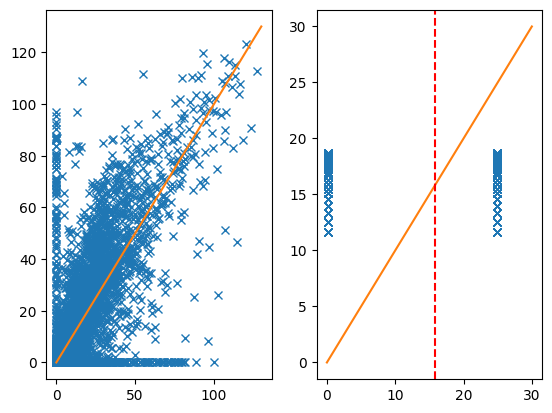

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.728  0.398E+00    31968    95.47  0.373   [Radiance 0.660 micron]
     2  -1.292  0.434E+00    31968    95.47  0.373   [Radiance 0.660 micron]
     3  -1.675  0.447E+00    31968    95.47  0.373   [Radiance 0.660 micron]
     4  -1.942  0.278E+00    32086    96.06  0.375   [Radiance 0.660 micron]
     5  -2.336  0.152E+00    32617    98.31  0.384   [Radiance 0.660 micron]
     6  -2.350  0.796E-01    35162   108.57  0.424   [Radiance 0.660 micron]
     7  -2.409  0.568E-01    38444   120.22  0.470   [Radiance 0.660 micron]
     8  -2.523  0.456E-01    41624   129.65  0.506   [Radiance 0.660 micron]
     9  -2.589  0.370E-01    46014   140.54  0.549   [Radiance 0.660 micron]
    10  -2.693  0.314E-01    50285   149.59  0.584   [Radiance 0.660 micron]
    11  -2.893  0.300E-01    51803   152.39  0.595   [Radiance 0.660 micron]
    12  -3.151  0.300E-01    51867   152.50  0.596   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

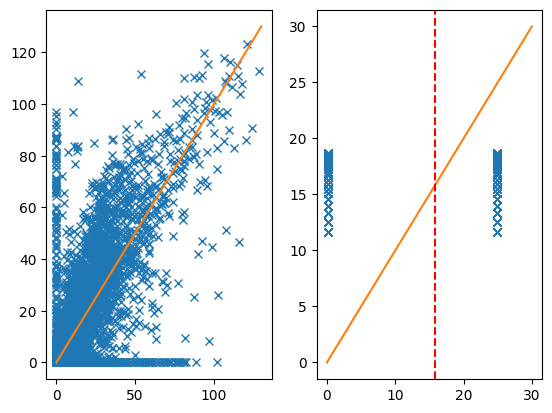

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.730  0.398E+00    31968    94.33  0.368   [Radiance 0.660 micron]
     2  -1.292  0.434E+00    31968    94.33  0.368   [Radiance 0.660 micron]
     3  -1.675  0.449E+00    31968    94.33  0.368   [Radiance 0.660 micron]
     4  -1.942  0.278E+00    32090    94.93  0.371   [Radiance 0.660 micron]
     5  -2.329  0.152E+00    32632    97.27  0.380   [Radiance 0.660 micron]
     6  -2.347  0.801E-01    35205   107.72  0.421   [Radiance 0.660 micron]
     7  -2.404  0.572E-01    38542   119.60  0.467   [Radiance 0.660 micron]
     8  -2.520  0.460E-01    41837   129.31  0.505   [Radiance 0.660 micron]
     9  -2.584  0.372E-01    46233   140.23  0.548   [Radiance 0.660 micron]
    10  -2.684  0.317E-01    50562   149.34  0.583   [Radiance 0.660 micron]
    11  -2.874  0.300E-01    52248   152.45  0.595   [Radiance 0.660 micron]
    12  -3.142  0.300E-01    52298   152.50  0.596   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

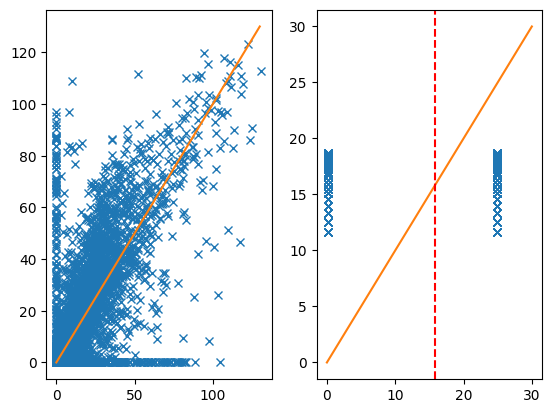

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.730  0.398E+00    31968    96.66  0.378   [Radiance 0.660 micron]
     2  -1.291  0.433E+00    31968    96.66  0.378   [Radiance 0.660 micron]
     3  -1.674  0.451E+00    31968    96.66  0.378   [Radiance 0.660 micron]
     4  -1.940  0.279E+00    32090    97.26  0.380   [Radiance 0.660 micron]
     5  -2.324  0.152E+00    32652    99.67  0.389   [Radiance 0.660 micron]
     6  -2.339  0.805E-01    35268   110.17  0.430   [Radiance 0.660 micron]
     7  -2.400  0.577E-01    38646   121.97  0.476   [Radiance 0.660 micron]
     8  -2.508  0.463E-01    42041   131.65  0.514   [Radiance 0.660 micron]
     9  -2.584  0.378E-01    46341   142.17  0.555   [Radiance 0.660 micron]
    10  -2.673  0.319E-01    50854   151.48  0.592   [Radiance 0.660 micron]
    11  -2.843  0.300E-01    52927   155.12  0.606   [Radiance 0.660 micron]
    12  -3.118  0.300E-01    53013   155.25  0.606   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

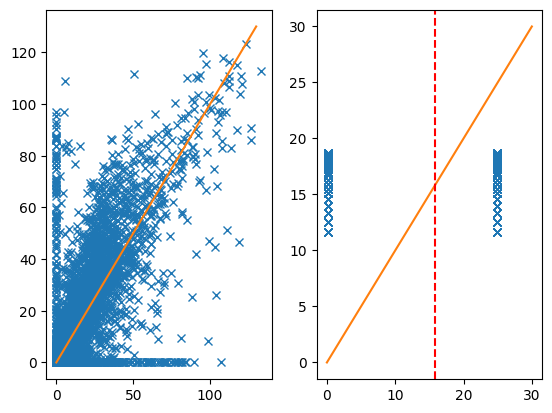

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.730  0.398E+00    31968    94.83  0.370   [Radiance 0.660 micron]
     2  -1.290  0.433E+00    31968    94.83  0.370   [Radiance 0.660 micron]
     3  -1.672  0.452E+00    31968    94.83  0.370   [Radiance 0.660 micron]
     4  -1.936  0.278E+00    32092    95.44  0.373   [Radiance 0.660 micron]
     5  -2.316  0.153E+00    32674    97.98  0.383   [Radiance 0.660 micron]
     6  -2.330  0.812E-01    35315   108.80  0.425   [Radiance 0.660 micron]
     7  -2.393  0.585E-01    38666   120.56  0.471   [Radiance 0.660 micron]
     8  -2.500  0.469E-01    41998   130.31  0.509   [Radiance 0.660 micron]
     9  -2.577  0.383E-01    46290   140.97  0.551   [Radiance 0.660 micron]
    10  -2.668  0.323E-01    50872   150.42  0.588   [Radiance 0.660 micron]
    11  -2.809  0.300E-01    53453   155.08  0.606   [Radiance 0.660 micron]
    12  -3.110  0.300E-01    53548   155.22  0.606   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

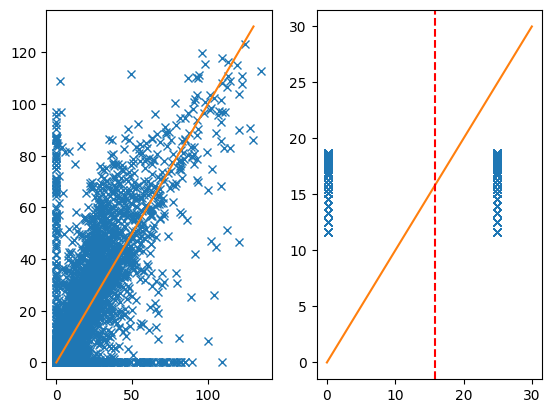

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.729  0.394E+00    31968    92.74  0.362   [Radiance 0.660 micron]
     2  -1.289  0.432E+00    31968    92.74  0.362   [Radiance 0.660 micron]
     3  -1.668  0.451E+00    31968    92.74  0.362   [Radiance 0.660 micron]
     4  -1.932  0.280E+00    32096    93.38  0.365   [Radiance 0.660 micron]
     5  -2.313  0.154E+00    32703    96.05  0.375   [Radiance 0.660 micron]
     6  -2.319  0.816E-01    35427   107.27  0.419   [Radiance 0.660 micron]
     7  -2.385  0.592E-01    38736   118.86  0.464   [Radiance 0.660 micron]
     8  -2.490  0.475E-01    42206   128.96  0.504   [Radiance 0.660 micron]
     9  -2.568  0.389E-01    46524   139.77  0.546   [Radiance 0.660 micron]
    10  -2.659  0.328E-01    51172   149.31  0.583   [Radiance 0.660 micron]
    11  -2.799  0.300E-01    54143   154.67  0.604   [Radiance 0.660 micron]
    12  -3.044  0.300E-01    54269   154.88  0.605   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

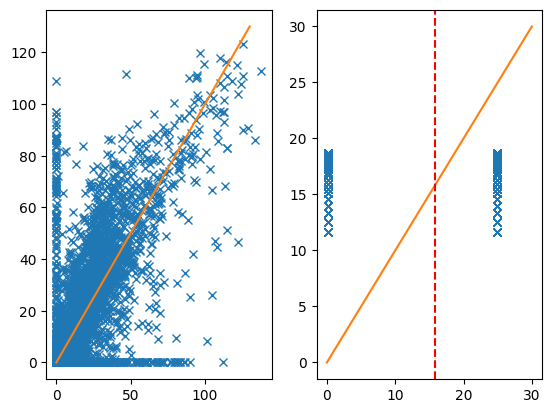

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.391E+00    31968    92.92  0.363   [Radiance 0.660 micron]
     2  -1.288  0.432E+00    31968    92.92  0.363   [Radiance 0.660 micron]
     3  -1.666  0.451E+00    31968    92.92  0.363   [Radiance 0.660 micron]
     4  -1.929  0.277E+00    32104    93.59  0.366   [Radiance 0.660 micron]
     5  -2.309  0.154E+00    32718    96.29  0.376   [Radiance 0.660 micron]
     6  -2.312  0.820E-01    35490   107.71  0.421   [Radiance 0.660 micron]
     7  -2.384  0.597E-01    38737   119.08  0.465   [Radiance 0.660 micron]
     8  -2.479  0.478E-01    42302   129.36  0.505   [Radiance 0.660 micron]
     9  -2.568  0.393E-01    46593   140.08  0.547   [Radiance 0.660 micron]
    10  -2.651  0.330E-01    51313   149.72  0.585   [Radiance 0.660 micron]
    11  -2.777  0.300E-01    54539   155.48  0.607   [Radiance 0.660 micron]
    12  -3.038  0.300E-01    54647   155.64  0.608   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

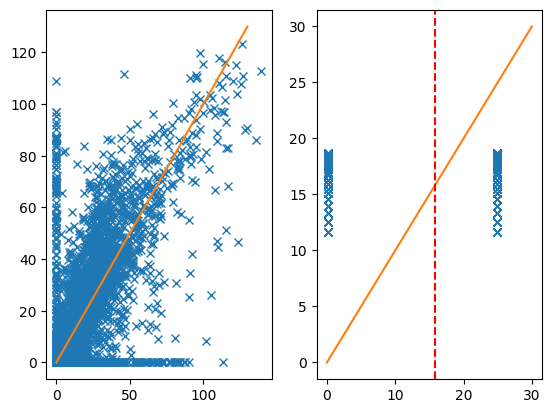

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.722  0.387E+00    31968    88.94  0.347   [Radiance 0.660 micron]
     2  -1.286  0.432E+00    31968    88.94  0.347   [Radiance 0.660 micron]
     3  -1.662  0.451E+00    31968    88.94  0.347   [Radiance 0.660 micron]
     4  -1.924  0.282E+00    32103    89.61  0.350   [Radiance 0.660 micron]
     5  -2.303  0.155E+00    32738    92.49  0.361   [Radiance 0.660 micron]
     6  -2.304  0.828E-01    35554   104.32  0.408   [Radiance 0.660 micron]
     7  -2.373  0.604E-01    38852   116.07  0.453   [Radiance 0.660 micron]
     8  -2.478  0.485E-01    42339   126.50  0.494   [Radiance 0.660 micron]
     9  -2.557  0.397E-01    46796   137.80  0.538   [Radiance 0.660 micron]
    10  -2.644  0.335E-01    51361   147.33  0.576   [Radiance 0.660 micron]
    11  -2.756  0.300E-01    55117   154.13  0.602   [Radiance 0.660 micron]
    12  -3.048  0.300E-01    55269   154.36  0.603   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

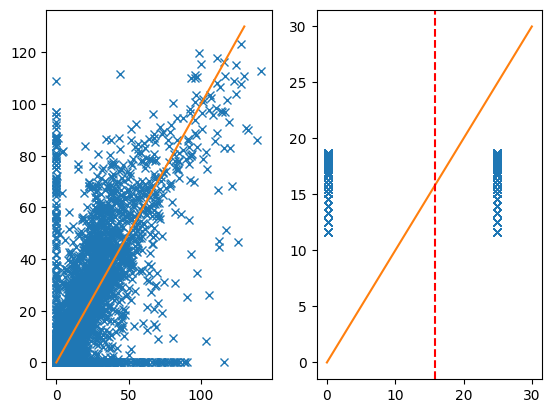

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.719  0.388E+00    31968    92.42  0.361   [Radiance 0.660 micron]
     2  -1.286  0.433E+00    31968    92.42  0.361   [Radiance 0.660 micron]
     3  -1.662  0.452E+00    31968    92.42  0.361   [Radiance 0.660 micron]
     4  -1.923  0.281E+00    32111    93.12  0.364   [Radiance 0.660 micron]
     5  -2.292  0.156E+00    32768    96.03  0.375   [Radiance 0.660 micron]
     6  -2.299  0.837E-01    35578   107.58  0.420   [Radiance 0.660 micron]
     7  -2.369  0.610E-01    39002   119.45  0.467   [Radiance 0.660 micron]
     8  -2.472  0.489E-01    42555   129.63  0.506   [Radiance 0.660 micron]
     9  -2.551  0.401E-01    47120   140.86  0.550   [Radiance 0.660 micron]
    10  -2.632  0.338E-01    51777   150.20  0.587   [Radiance 0.660 micron]
    11  -2.737  0.300E-01    55978   157.44  0.615   [Radiance 0.660 micron]
    12  -3.043  0.300E-01    56161   157.68  0.616   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

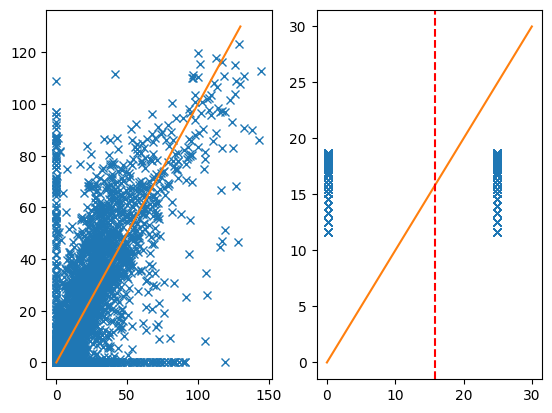

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.717  0.390E+00    31968    94.35  0.369   [Radiance 0.660 micron]
     2  -1.287  0.435E+00    31968    94.35  0.369   [Radiance 0.660 micron]
     3  -1.662  0.454E+00    31968    94.35  0.369   [Radiance 0.660 micron]
     4  -1.923  0.284E+00    32111    95.04  0.371   [Radiance 0.660 micron]
     5  -2.291  0.156E+00    32808    98.09  0.383   [Radiance 0.660 micron]
     6  -2.295  0.839E-01    35669   109.73  0.429   [Radiance 0.660 micron]
     7  -2.368  0.613E-01    39049   121.32  0.474   [Radiance 0.660 micron]
     8  -2.467  0.491E-01    42699   131.71  0.514   [Radiance 0.660 micron]
     9  -2.551  0.403E-01    47193   142.53  0.557   [Radiance 0.660 micron]
    10  -2.638  0.339E-01    51948   152.01  0.594   [Radiance 0.660 micron]
    11  -2.733  0.300E-01    56326   159.39  0.623   [Radiance 0.660 micron]
    12  -3.039  0.300E-01    56504   159.60  0.623   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

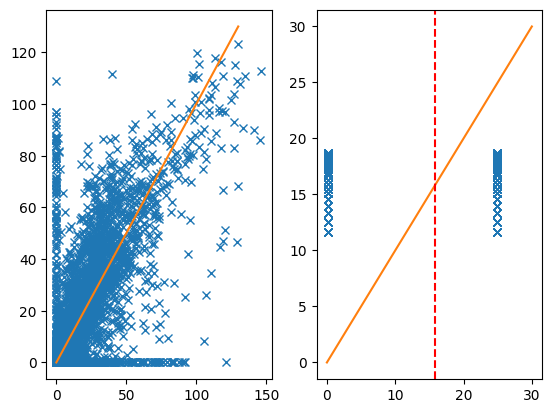

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.720  0.392E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.437E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.457E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.924  0.279E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.288  0.156E+00    32812   103.22  0.403   [Radiance 0.660 micron]
     6  -2.295  0.842E-01    35714   114.64  0.448   [Radiance 0.660 micron]
     7  -2.370  0.614E-01    39121   125.84  0.492   [Radiance 0.660 micron]
     8  -2.468  0.491E-01    42794   135.95  0.531   [Radiance 0.660 micron]
     9  -2.547  0.403E-01    47289   146.35  0.572   [Radiance 0.660 micron]
    10  -2.628  0.340E-01    52141   155.56  0.608   [Radiance 0.660 micron]
    11  -2.739  0.300E-01    56565   162.84  0.636   [Radiance 0.660 micron]
    12  -3.025  0.300E-01    56743   163.02  0.637   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

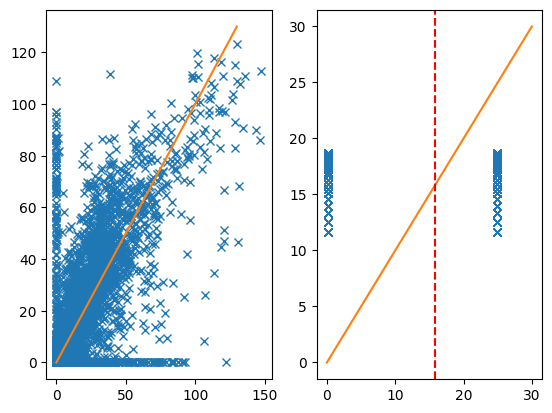


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351     25     46  23755     0 15193   5.226D-01   3.729D+03
  F =   3729.0687021399617     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [21]:
warnings.filterwarnings('ignore')
initial_gridded_extinction = solvers_reconstruct[0.66].medium['cloud'].density.data
initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data*0 + 25
initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
            state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))


optimizer._options['maxiter'] = 25
result = optimizer.minimize(x0)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.408E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.295  0.454E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.656  0.476E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.909  0.292E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.262  0.162E+00    32911   103.62  0.405   [Radiance 0.660 micron]
     6  -2.283  0.881E-01    35975   115.52  0.451   [Radiance 0.660 micron]
     7  -2.355  0.637E-01    39801   127.75  0.499   [Radiance 0.660 micron]
     8  -2.458  0.508E-01    43920   138.71  0.542   [Radiance 0.660 micron]
     9  -2.539  0.414E-01    48905   149.50  0.584   [Radiance 0.660 micron]
    10  -2.604  0.347E-01    54597   159.64  0.624   [Radiance 0.660 micron]
    11  -2.728  0.300E-01    60438   168.15  0.657   [Radiance 0.660 micron]
    12  -3.007  0.300E-01    60650   168.33  0.658   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

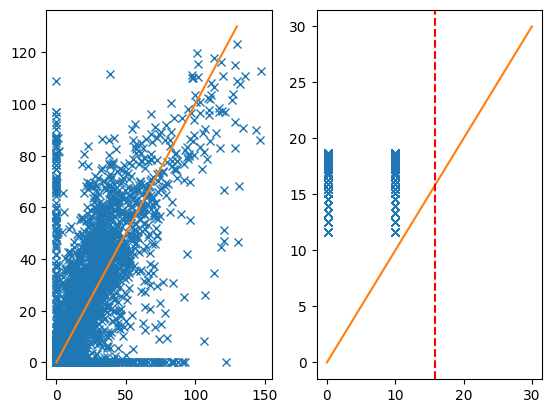

10521.908677424017
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.725  0.406E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.294  0.452E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.657  0.474E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.912  0.293E+00    32115   100.29  0.392   [Radiance 0.660 micron]
     5  -2.268  0.161E+00    32889   103.53  0.404   [Radiance 0.660 micron]
     6  -2.283  0.873E-01    35974   115.52  0.451   [Radiance 0.660 micron]
     7  -2.357  0.633E-01    39698   127.50  0.498   [Radiance 0.660 micron]
     8  -2.458  0.505E-01    43758   138.29  0.540   [Radiance 0.660 micron]
     9  -2.542  0.412E-01    48645   148.98  0.582   [Radiance 0.660 micron]
    10  -2.614  0.346E-01    54240   159.07  0.621   [Radiance 0.660 micron]
    11  -2.720  0.300E-01    59905   167.50  0.654   [Radiance 0.660 micron]
    12  -3.002  0.300E-01    60122   167.70  0.655   [Radian

<Figure size 640x480 with 0 Axes>

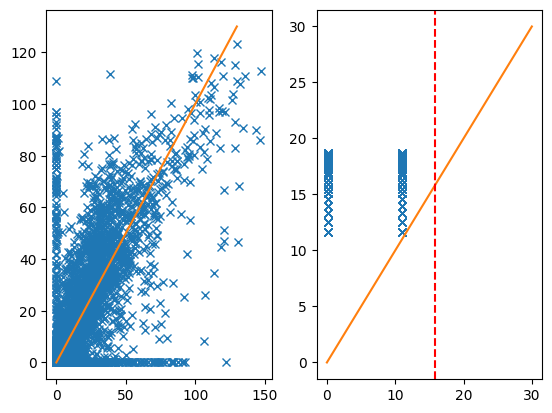

8724.284228896055
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.724  0.404E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.294  0.450E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.658  0.471E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.914  0.290E+00    32115   100.29  0.392   [Radiance 0.660 micron]
     5  -2.272  0.160E+00    32879   103.48  0.404   [Radiance 0.660 micron]
     6  -2.285  0.868E-01    35946   115.42  0.451   [Radiance 0.660 micron]
     7  -2.358  0.630E-01    39641   127.34  0.497   [Radiance 0.660 micron]
     8  -2.460  0.504E-01    43575   137.85  0.538   [Radiance 0.660 micron]
     9  -2.539  0.411E-01    48477   148.66  0.581   [Radiance 0.660 micron]
    10  -2.623  0.346E-01    53844   158.40  0.619   [Radiance 0.660 micron]
    11  -2.715  0.300E-01    59447   166.88  0.652   [Radiance 0.660 micron]
    12  -3.004  0.300E-01    59672   167.11  0.653   [Radianc

<Figure size 640x480 with 0 Axes>

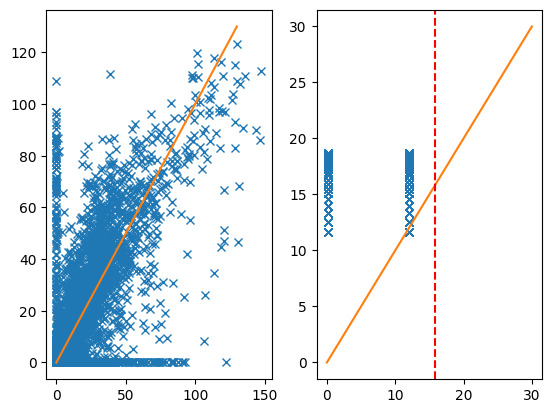

7407.414722868481
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.724  0.402E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.293  0.448E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.659  0.469E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.915  0.289E+00    32115   100.29  0.392   [Radiance 0.660 micron]
     5  -2.274  0.160E+00    32875   103.46  0.404   [Radiance 0.660 micron]
     6  -2.287  0.864E-01    35903   115.30  0.450   [Radiance 0.660 micron]
     7  -2.362  0.627E-01    39561   127.12  0.497   [Radiance 0.660 micron]
     8  -2.458  0.501E-01    43521   137.71  0.538   [Radiance 0.660 micron]
     9  -2.543  0.410E-01    48254   148.24  0.579   [Radiance 0.660 micron]
    10  -2.621  0.345E-01    53652   158.10  0.618   [Radiance 0.660 micron]
    11  -2.715  0.300E-01    59025   166.30  0.650   [Radiance 0.660 micron]
    12  -3.003  0.300E-01    59234   166.52  0.650   [Radianc

<Figure size 640x480 with 0 Axes>

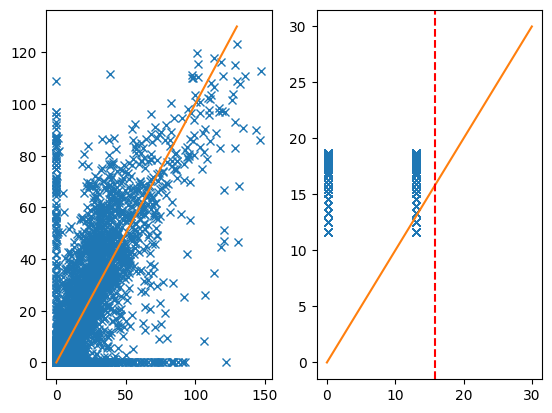

6420.865456263675
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.723  0.401E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.293  0.446E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.660  0.468E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.917  0.289E+00    32115   100.29  0.392   [Radiance 0.660 micron]
     5  -2.277  0.159E+00    32865   103.42  0.404   [Radiance 0.660 micron]
     6  -2.289  0.860E-01    35885   115.25  0.450   [Radiance 0.660 micron]
     7  -2.364  0.625E-01    39488   126.92  0.496   [Radiance 0.660 micron]
     8  -2.457  0.498E-01    43447   137.55  0.537   [Radiance 0.660 micron]
     9  -2.542  0.410E-01    48091   147.89  0.578   [Radiance 0.660 micron]
    10  -2.625  0.345E-01    53385   157.66  0.616   [Radiance 0.660 micron]
    11  -2.717  0.300E-01    58651   165.78  0.648   [Radiance 0.660 micron]
    12  -3.013  0.300E-01    58857   166.02  0.649   [Radianc

<Figure size 640x480 with 0 Axes>

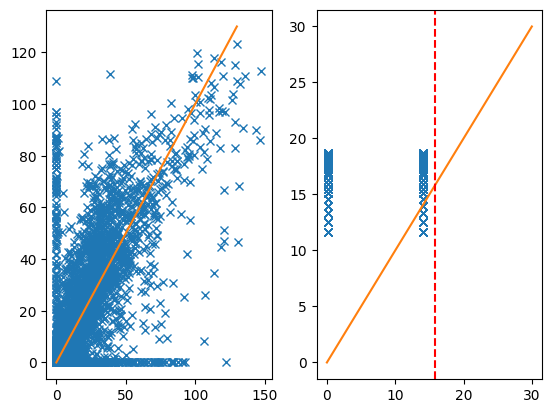

5682.296225157306
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.723  0.400E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.292  0.445E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.661  0.466E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.918  0.288E+00    32115   100.29  0.392   [Radiance 0.660 micron]
     5  -2.278  0.159E+00    32863   103.41  0.404   [Radiance 0.660 micron]
     6  -2.290  0.857E-01    35862   115.16  0.450   [Radiance 0.660 micron]
     7  -2.365  0.623E-01    39412   126.68  0.495   [Radiance 0.660 micron]
     8  -2.460  0.497E-01    43343   137.29  0.536   [Radiance 0.660 micron]
     9  -2.543  0.408E-01    47993   147.70  0.577   [Radiance 0.660 micron]
    10  -2.625  0.344E-01    53186   157.32  0.615   [Radiance 0.660 micron]
    11  -2.720  0.300E-01    58323   165.32  0.646   [Radiance 0.660 micron]
    12  -3.015  0.300E-01    58503   165.52  0.647   [Radianc

<Figure size 640x480 with 0 Axes>

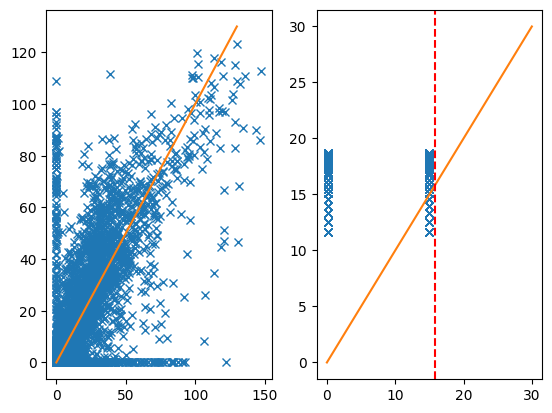

5136.228088956824
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.722  0.398E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.292  0.444E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.661  0.465E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.919  0.288E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.281  0.158E+00    32856   103.38  0.404   [Radiance 0.660 micron]
     6  -2.290  0.854E-01    35856   115.15  0.450   [Radiance 0.660 micron]
     7  -2.367  0.622E-01    39342   126.49  0.494   [Radiance 0.660 micron]
     8  -2.460  0.496E-01    43239   137.05  0.535   [Radiance 0.660 micron]
     9  -2.544  0.408E-01    47886   147.52  0.576   [Radiance 0.660 micron]
    10  -2.625  0.343E-01    53044   157.08  0.614   [Radiance 0.660 micron]
    11  -2.721  0.300E-01    58066   164.98  0.644   [Radiance 0.660 micron]
    12  -3.015  0.300E-01    58254   165.18  0.645   [Radianc

<Figure size 640x480 with 0 Axes>

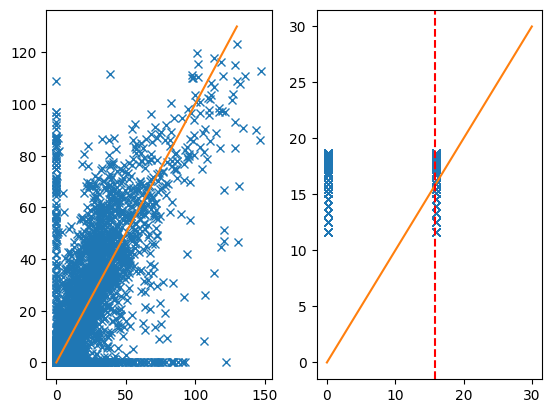

4723.93410945889
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.722  0.397E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.292  0.443E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.662  0.463E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.920  0.287E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.284  0.158E+00    32841   103.33  0.404   [Radiance 0.660 micron]
     6  -2.289  0.851E-01    35833   115.07  0.449   [Radiance 0.660 micron]
     7  -2.368  0.621E-01    39300   126.36  0.494   [Radiance 0.660 micron]
     8  -2.459  0.495E-01    43146   136.79  0.534   [Radiance 0.660 micron]
     9  -2.545  0.408E-01    47724   147.18  0.575   [Radiance 0.660 micron]
    10  -2.624  0.343E-01    52864   156.75  0.612   [Radiance 0.660 micron]
    11  -2.722  0.300E-01    57851   164.71  0.643   [Radiance 0.660 micron]
    12  -3.016  0.300E-01    58035   164.90  0.644   [Radiance

<Figure size 640x480 with 0 Axes>

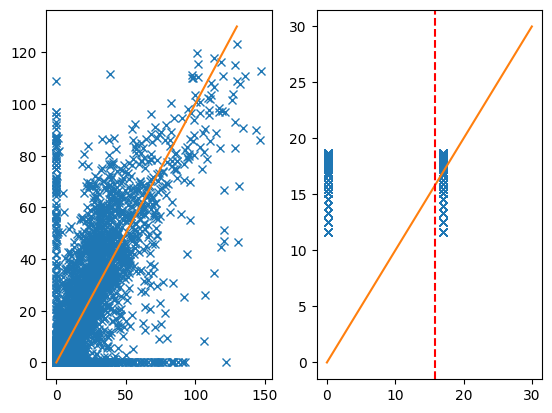

4414.461925411059
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.721  0.397E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.291  0.442E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.662  0.462E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.921  0.287E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.285  0.157E+00    32840   103.32  0.404   [Radiance 0.660 micron]
     6  -2.290  0.849E-01    35818   115.02  0.449   [Radiance 0.660 micron]
     7  -2.368  0.620E-01    39244   126.19  0.493   [Radiance 0.660 micron]
     8  -2.462  0.494E-01    43101   136.71  0.534   [Radiance 0.660 micron]
     9  -2.546  0.407E-01    47628   147.02  0.574   [Radiance 0.660 micron]
    10  -2.625  0.342E-01    52755   156.60  0.612   [Radiance 0.660 micron]
    11  -2.722  0.300E-01    57630   164.41  0.642   [Radiance 0.660 micron]
    12  -3.024  0.300E-01    57801   164.57  0.643   [Radianc

<Figure size 640x480 with 0 Axes>

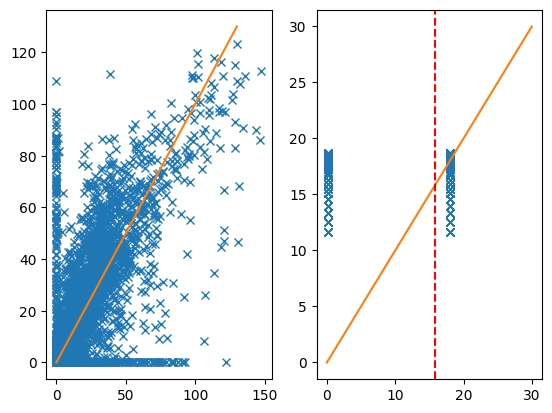

4191.272263902254
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.721  0.396E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.291  0.441E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.662  0.461E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.922  0.286E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.286  0.158E+00    32835   103.30  0.404   [Radiance 0.660 micron]
     6  -2.290  0.847E-01    35808   114.99  0.449   [Radiance 0.660 micron]
     7  -2.369  0.619E-01    39216   126.10  0.493   [Radiance 0.660 micron]
     8  -2.463  0.493E-01    43046   136.56  0.533   [Radiance 0.660 micron]
     9  -2.545  0.406E-01    47583   146.93  0.574   [Radiance 0.660 micron]
    10  -2.627  0.342E-01    52600   156.32  0.611   [Radiance 0.660 micron]
    11  -2.723  0.300E-01    57408   164.08  0.641   [Radiance 0.660 micron]
    12  -3.024  0.300E-01    57585   164.25  0.642   [Radianc

<Figure size 640x480 with 0 Axes>

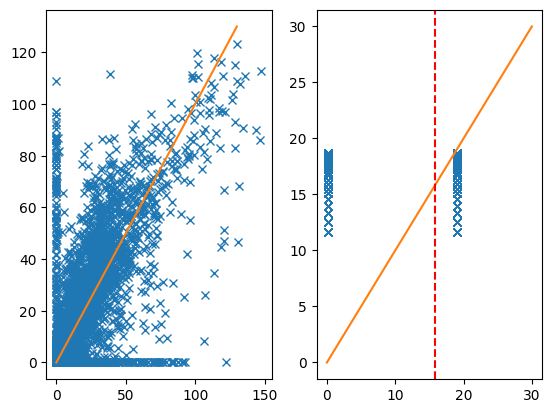

4020.5538027736557
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.721  0.395E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.291  0.440E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.663  0.460E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.922  0.286E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.287  0.157E+00    32831   103.29  0.403   [Radiance 0.660 micron]
     6  -2.291  0.846E-01    35790   114.93  0.449   [Radiance 0.660 micron]
     7  -2.370  0.618E-01    39201   126.06  0.492   [Radiance 0.660 micron]
     8  -2.463  0.493E-01    43006   136.47  0.533   [Radiance 0.660 micron]
     9  -2.547  0.405E-01    47497   146.77  0.573   [Radiance 0.660 micron]
    10  -2.625  0.341E-01    52528   156.19  0.610   [Radiance 0.660 micron]
    11  -2.728  0.300E-01    57222   163.79  0.640   [Radiance 0.660 micron]
    12  -3.028  0.300E-01    57397   163.99  0.641   [Radian

<Figure size 640x480 with 0 Axes>

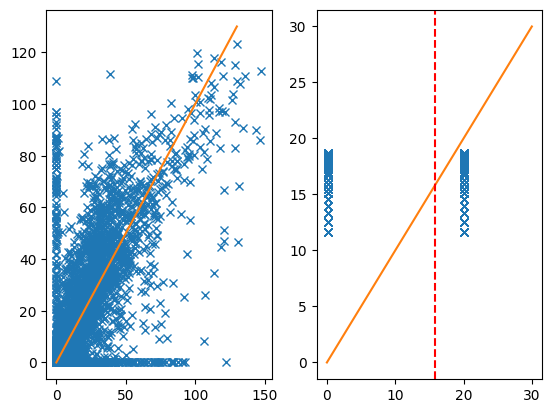

3900.539245050456
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.721  0.394E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.291  0.439E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.663  0.460E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.923  0.285E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.288  0.157E+00    32824   103.26  0.403   [Radiance 0.660 micron]
     6  -2.291  0.844E-01    35776   114.87  0.449   [Radiance 0.660 micron]
     7  -2.369  0.617E-01    39182   125.99  0.492   [Radiance 0.660 micron]
     8  -2.465  0.493E-01    42959   136.37  0.533   [Radiance 0.660 micron]
     9  -2.548  0.405E-01    47438   146.63  0.573   [Radiance 0.660 micron]
    10  -2.626  0.341E-01    52482   156.11  0.610   [Radiance 0.660 micron]
    11  -2.733  0.300E-01    57086   163.61  0.639   [Radiance 0.660 micron]
    12  -3.029  0.300E-01    57264   163.82  0.640   [Radianc

<Figure size 640x480 with 0 Axes>

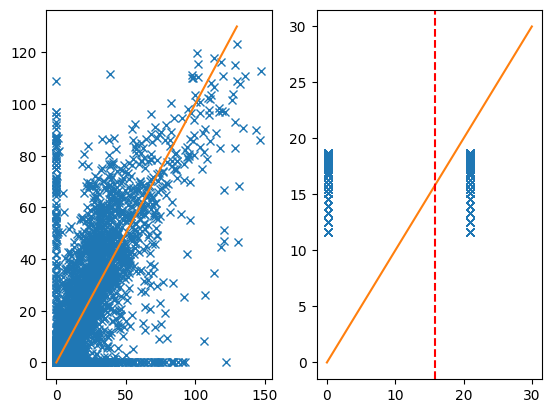

3819.7183233132337
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.720  0.394E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.439E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.663  0.459E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.923  0.285E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.289  0.157E+00    32821   103.25  0.403   [Radiance 0.660 micron]
     6  -2.292  0.843E-01    35760   114.82  0.449   [Radiance 0.660 micron]
     7  -2.370  0.616E-01    39164   125.95  0.492   [Radiance 0.660 micron]
     8  -2.466  0.492E-01    42922   136.28  0.532   [Radiance 0.660 micron]
     9  -2.548  0.404E-01    47407   146.60  0.573   [Radiance 0.660 micron]
    10  -2.627  0.341E-01    52373   155.93  0.609   [Radiance 0.660 micron]
    11  -2.734  0.300E-01    56949   163.42  0.638   [Radiance 0.660 micron]
    12  -3.029  0.300E-01    57121   163.60  0.639   [Radian

<Figure size 640x480 with 0 Axes>

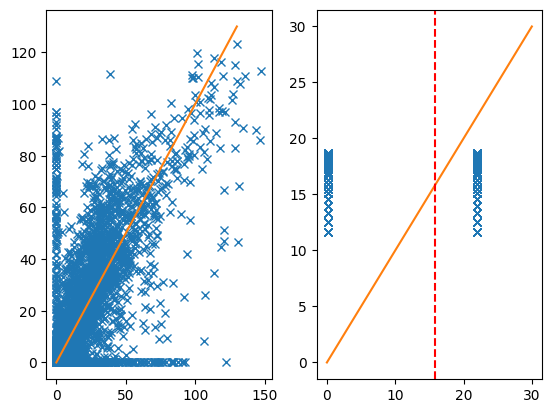

3767.5653219547344
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.720  0.393E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.438E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.663  0.458E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.924  0.285E+00    32112   100.27  0.392   [Radiance 0.660 micron]
     5  -2.290  0.156E+00    32817   103.23  0.403   [Radiance 0.660 micron]
     6  -2.292  0.841E-01    35758   114.81  0.448   [Radiance 0.660 micron]
     7  -2.369  0.615E-01    39155   125.92  0.492   [Radiance 0.660 micron]
     8  -2.467  0.492E-01    42866   136.14  0.532   [Radiance 0.660 micron]
     9  -2.548  0.403E-01    47378   146.53  0.572   [Radiance 0.660 micron]
    10  -2.628  0.340E-01    52293   155.81  0.609   [Radiance 0.660 micron]
    11  -2.737  0.300E-01    56817   163.22  0.638   [Radiance 0.660 micron]
    12  -3.026  0.300E-01    56977   163.37  0.638   [Radian

<Figure size 640x480 with 0 Axes>

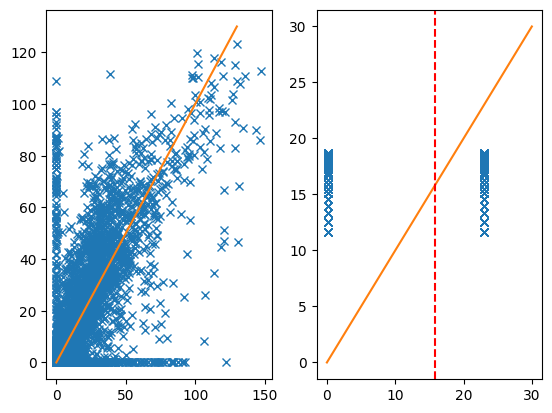

3737.741771192191
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.720  0.393E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.437E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.457E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.924  0.280E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.288  0.156E+00    32817   103.23  0.403   [Radiance 0.660 micron]
     6  -2.294  0.843E-01    35723   114.68  0.448   [Radiance 0.660 micron]
     7  -2.369  0.615E-01    39129   125.87  0.492   [Radiance 0.660 micron]
     8  -2.468  0.492E-01    42817   136.01  0.531   [Radiance 0.660 micron]
     9  -2.546  0.403E-01    47347   146.46  0.572   [Radiance 0.660 micron]
    10  -2.630  0.341E-01    52164   155.59  0.608   [Radiance 0.660 micron]
    11  -2.738  0.300E-01    56686   163.04  0.637   [Radiance 0.660 micron]
    12  -3.023  0.300E-01    56866   163.22  0.638   [Radianc

<Figure size 640x480 with 0 Axes>

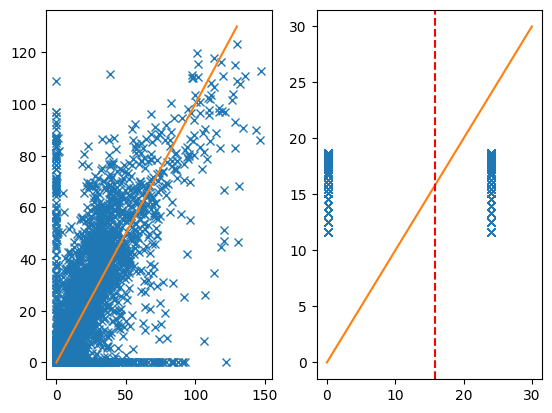

3725.2976820917056


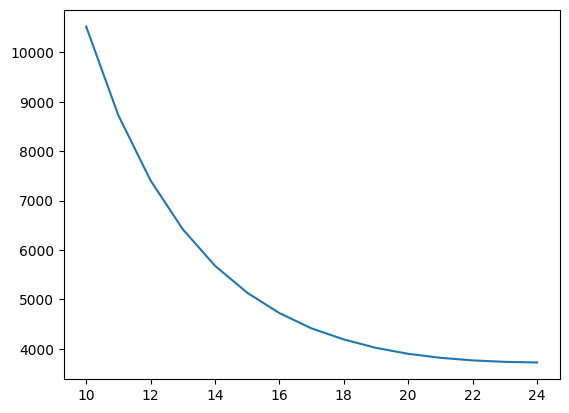

In [22]:
losses = []
for i in range(10, 25):
    solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers_reconstruct[0.66].medium['cloud'].reff.data * 0 + i
    initial_gridded_extinction = solvers_reconstruct[0.66].medium['cloud'].density.data
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers_reconstruct[0.66].medium['cloud'].reff.data
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    loss = objective_function(x0)[0]
    plot(None)
    print(loss)
    losses.append(loss)
py.plot(range(10, 25), losses)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.720  0.392E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.437E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.457E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.924  0.279E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.288  0.156E+00    32810   103.21  0.403   [Radiance 0.660 micron]
     6  -2.295  0.841E-01    35716   114.65  0.448   [Radiance 0.660 micron]
     7  -2.370  0.614E-01    39119   125.84  0.492   [Radiance 0.660 micron]
     8  -2.468  0.491E-01    42793   135.94  0.531   [Radiance 0.660 micron]
     9  -2.547  0.403E-01    47289   146.35  0.572   [Radiance 0.660 micron]
    10  -2.629  0.340E-01    52141   155.56  0.608   [Radiance 0.660 micron]
    11  -2.739  0.300E-01    56553   162.82  0.636   [Radiance 0.660 micron]
    12  -3.025  0.300E-01    56733   163.00  0.637   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

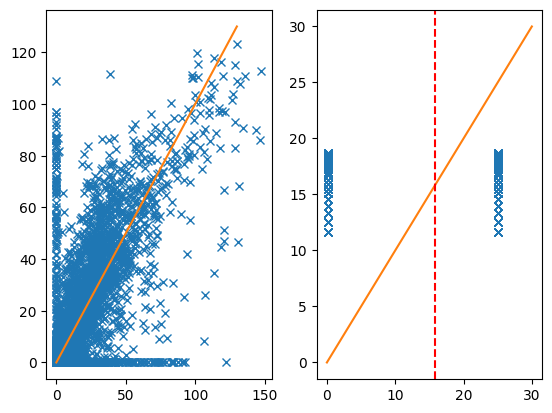

3730.1156937858705
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.720  0.392E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.436E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.456E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.925  0.279E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.289  0.156E+00    32807   103.20  0.403   [Radiance 0.660 micron]
     6  -2.295  0.840E-01    35705   114.61  0.448   [Radiance 0.660 micron]
     7  -2.370  0.613E-01    39102   125.78  0.491   [Radiance 0.660 micron]
     8  -2.468  0.491E-01    42776   135.90  0.531   [Radiance 0.660 micron]
     9  -2.549  0.402E-01    47231   146.24  0.571   [Radiance 0.660 micron]
    10  -2.627  0.340E-01    52134   155.55  0.608   [Radiance 0.660 micron]
    11  -2.741  0.300E-01    56457   162.70  0.636   [Radiance 0.660 micron]
    12  -3.025  0.300E-01    56641   162.89  0.636   [Radian

<Figure size 640x480 with 0 Axes>

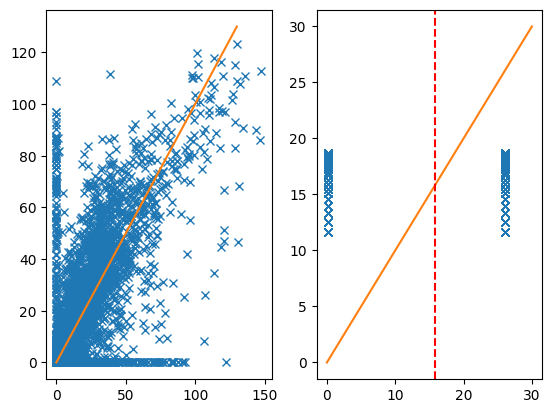

3744.732357327245
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.719  0.391E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.290  0.436E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.456E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.925  0.278E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.290  0.156E+00    32798   103.17  0.403   [Radiance 0.660 micron]
     6  -2.295  0.840E-01    35698   114.58  0.448   [Radiance 0.660 micron]
     7  -2.370  0.613E-01    39082   125.73  0.491   [Radiance 0.660 micron]
     8  -2.470  0.490E-01    42728   135.79  0.530   [Radiance 0.660 micron]
     9  -2.548  0.402E-01    47220   146.22  0.571   [Radiance 0.660 micron]
    10  -2.629  0.340E-01    52089   155.47  0.607   [Radiance 0.660 micron]
    11  -2.740  0.300E-01    56376   162.57  0.635   [Radiance 0.660 micron]
    12  -3.028  0.300E-01    56556   162.76  0.636   [Radianc

<Figure size 640x480 with 0 Axes>

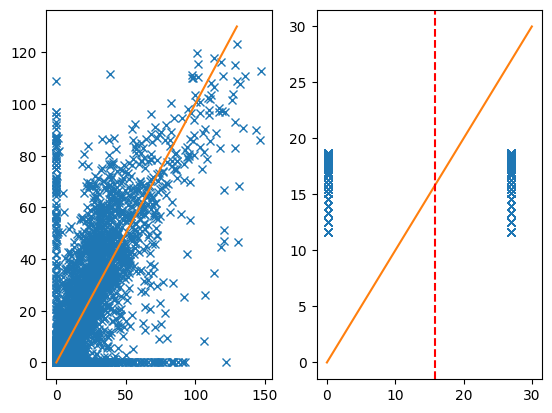

3769.1431038274673
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.719  0.391E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.289  0.435E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.455E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.925  0.278E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.290  0.156E+00    32798   103.17  0.403   [Radiance 0.660 micron]
     6  -2.296  0.839E-01    35684   114.54  0.447   [Radiance 0.660 micron]
     7  -2.370  0.612E-01    39066   125.68  0.491   [Radiance 0.660 micron]
     8  -2.468  0.490E-01    42706   135.73  0.530   [Radiance 0.660 micron]
     9  -2.551  0.403E-01    47139   146.03  0.570   [Radiance 0.660 micron]
    10  -2.629  0.339E-01    52083   155.46  0.607   [Radiance 0.660 micron]
    11  -2.742  0.300E-01    56310   162.46  0.635   [Radiance 0.660 micron]
    12  -3.030  0.300E-01    56491   162.65  0.635   [Radian

<Figure size 640x480 with 0 Axes>

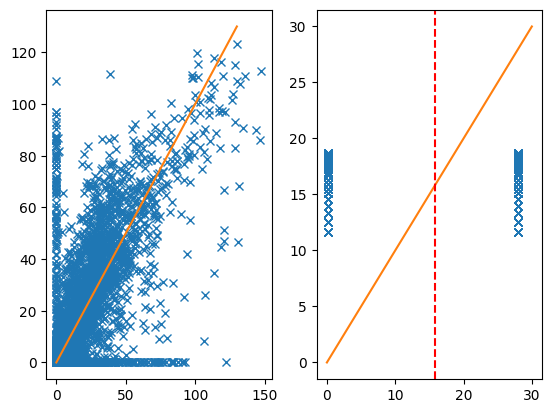

3798.676817608679
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.719  0.390E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.289  0.435E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.664  0.455E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.926  0.278E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.291  0.156E+00    32796   103.17  0.403   [Radiance 0.660 micron]
     6  -2.296  0.838E-01    35682   114.53  0.447   [Radiance 0.660 micron]
     7  -2.370  0.612E-01    39044   125.62  0.491   [Radiance 0.660 micron]
     8  -2.466  0.490E-01    42699   135.71  0.530   [Radiance 0.660 micron]
     9  -2.554  0.403E-01    47049   145.87  0.570   [Radiance 0.660 micron]
    10  -2.626  0.338E-01    52072   155.44  0.607   [Radiance 0.660 micron]
    11  -2.743  0.300E-01    56228   162.34  0.634   [Radiance 0.660 micron]
    12  -3.031  0.300E-01    56421   162.55  0.635   [Radianc

<Figure size 640x480 with 0 Axes>

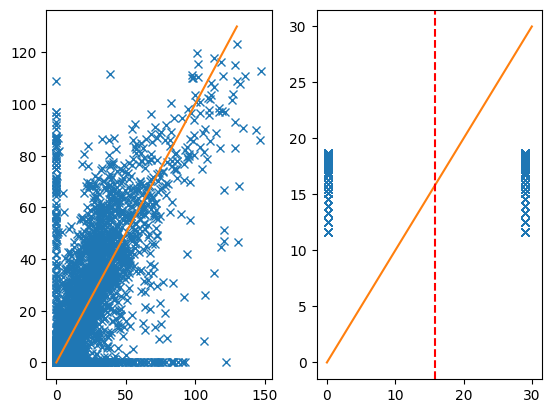

3836.0389037906843


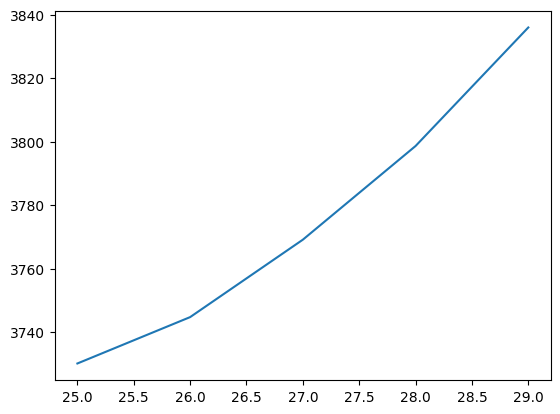

In [24]:
losses = []
for i in range(25, 30):
    solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers_reconstruct[0.66].medium['cloud'].reff.data * 0 + i
    initial_gridded_extinction = solvers_reconstruct[0.66].medium['cloud'].density.data
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers_reconstruct[0.66].medium['cloud'].reff.data
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    loss = objective_function(x0)[0]
    plot(None)
    print(loss)
    losses.append(loss)
py.plot(range(25, 30), losses)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.726  0.408E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     2  -1.295  0.454E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     3  -1.656  0.476E+00    31968    99.60  0.389   [Radiance 0.660 micron]
     4  -1.909  0.292E+00    32120   100.31  0.392   [Radiance 0.660 micron]
     5  -2.262  0.162E+00    32911   103.62  0.405   [Radiance 0.660 micron]
     6  -2.283  0.881E-01    35975   115.52  0.451   [Radiance 0.660 micron]
     7  -2.355  0.637E-01    39801   127.75  0.499   [Radiance 0.660 micron]
     8  -2.458  0.508E-01    43920   138.71  0.542   [Radiance 0.660 micron]
     9  -2.539  0.414E-01    48905   149.50  0.584   [Radiance 0.660 micron]
    10  -2.604  0.347E-01    54597   159.64  0.624   [Radiance 0.660 micron]
    11  -2.728  0.300E-01    60438   168.15  0.657   [Radiance 0.660 micron]
    12  -3.007  0.300E-01    60650   168.33  0.658   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

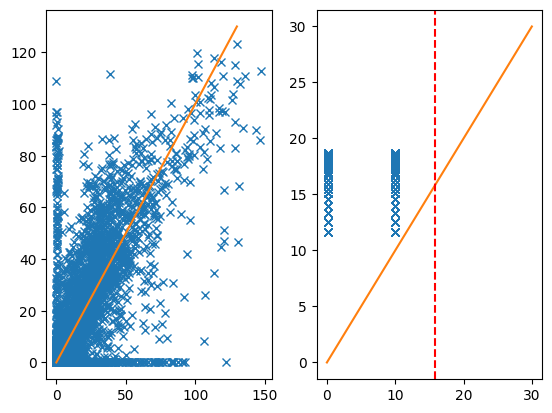


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1      3   2592     0 14036   3.591D+00   9.145D+03
  F =   9144.5310717305056     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.734  0.390E+00    31968   139.62  0.545   [Radiance 0.660 micron]
     2  -1.317  0.435E+00    31968   139.62  0.545   [Radiance 0.660 micron]
     3  -1.690  0.455E+00    31968   139.62  0.545   [Radiance 0.660 micron]
     4  -1.948  0.273E+00    32125   140.18  0.548   [Radiance 0.660 micron]
     5  -2.321  0.150E+00    32893   142.

<Figure size 640x480 with 0 Axes>

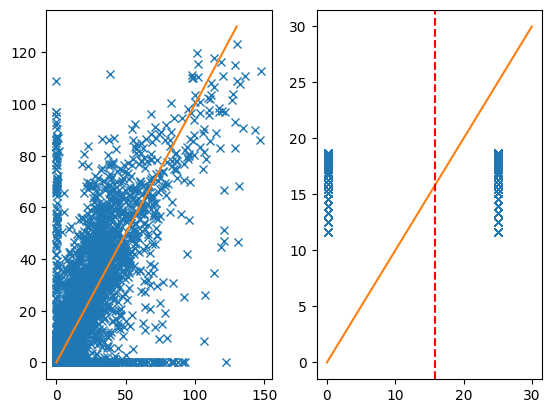


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1      2   5207     0 15831   2.374D+00   3.779D+03
  F =   3779.0058171450737     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.409E+00    31968   105.73  0.413   [Radiance 0.660 micron]
     2  -1.296  0.455E+00    31968   105.73  0.413   [Radiance 0.660 micron]
     3  -1.657  0.477E+00    31968   105.73  0.413   [Radiance 0.660 micron]
     4  -1.910  0.292E+00    32120   106.41  0.416   [Radiance 0.660 micron]
     5  -2.265  0.162E+00    32903   109.

<Figure size 640x480 with 0 Axes>

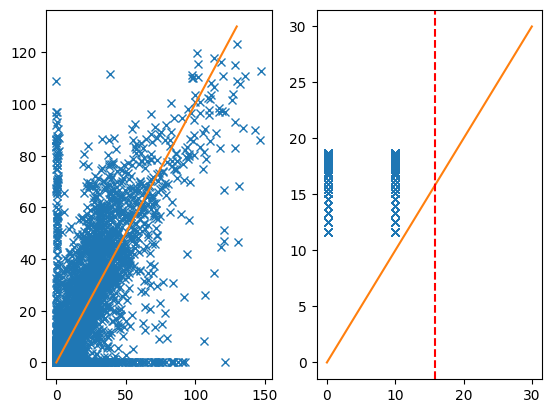


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1      3   3307     0 14328   3.481D+00   9.066D+03
  F =   9066.2005299125485     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.734  0.391E+00    31968   142.88  0.558   [Radiance 0.660 micron]
     2  -1.317  0.436E+00    31968   142.88  0.558   [Radiance 0.660 micron]
     3  -1.689  0.455E+00    31968   142.88  0.558   [Radiance 0.660 micron]
     4  -1.948  0.273E+00    32125   143.44  0.560   [Radiance 0.660 micron]
     5  -2.321  0.150E+00    32878   145.

<Figure size 640x480 with 0 Axes>

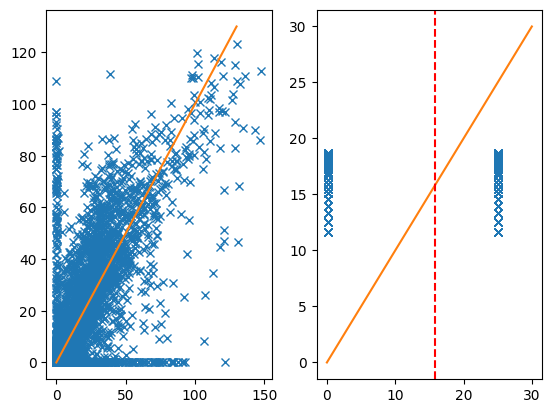


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1      2   5531     0 15791   2.997D+00   3.811D+03
  F =   3811.4939549120550     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.728  0.410E+00    31968   106.04  0.414   [Radiance 0.660 micron]
     2  -1.295  0.456E+00    31968   106.04  0.414   [Radiance 0.660 micron]
     3  -1.656  0.478E+00    31968   106.04  0.414   [Radiance 0.660 micron]
     4  -1.910  0.295E+00    32115   106.69  0.417   [Radiance 0.660 micron]
     5  -2.266  0.163E+00    32887   109.

<Figure size 640x480 with 0 Axes>

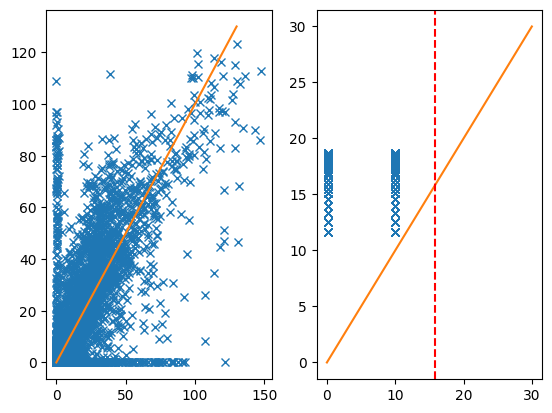


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1      3   3588     0 14252   3.336D+00   8.948D+03
  F =   8947.5644175986545     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.734  0.392E+00    31968   145.64  0.569   [Radiance 0.660 micron]
     2  -1.318  0.436E+00    31968   145.64  0.569   [Radiance 0.660 micron]
     3  -1.690  0.456E+00    31968   145.64  0.569   [Radiance 0.660 micron]
     4  -1.948  0.270E+00    32126   146.19  0.571   [Radiance 0.660 micron]
     5  -2.322  0.150E+00    32878   148.

<Figure size 640x480 with 0 Axes>

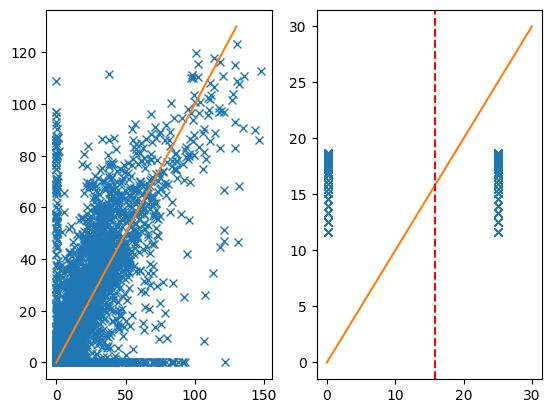


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1      2   5523     0 15449   3.230D+00   3.824D+03
  F =   3823.6267831235073     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.729  0.411E+00    31968   108.68  0.425   [Radiance 0.660 micron]
     2  -1.296  0.457E+00    31968   108.68  0.425   [Radiance 0.660 micron]
     3  -1.657  0.479E+00    31968   108.68  0.425   [Radiance 0.660 micron]
     4  -1.911  0.294E+00    32115   109.32  0.427   [Radiance 0.660 micron]
     5  -2.266  0.163E+00    32888   112.

<Figure size 640x480 with 0 Axes>

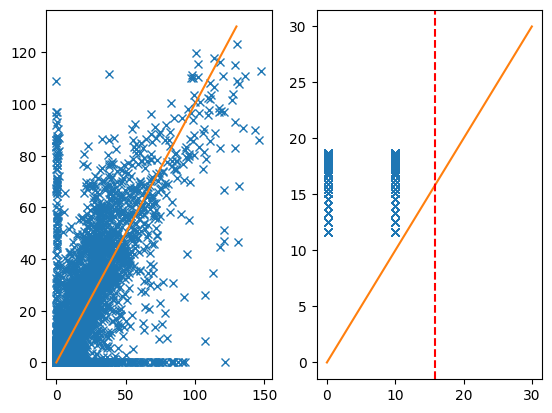


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1      3   4048     0 14377   3.233D+00   8.825D+03
  F =   8825.0441715752586     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.735  0.393E+00    31968   148.23  0.579   [Radiance 0.660 micron]
     2  -1.319  0.437E+00    31968   148.23  0.579   [Radiance 0.660 micron]
     3  -1.691  0.457E+00    31968   148.23  0.579   [Radiance 0.660 micron]
     4  -1.949  0.273E+00    32124   148.75  0.581   [Radiance 0.660 micron]
     5  -2.323  0.150E+00    32885   151.

<Figure size 640x480 with 0 Axes>

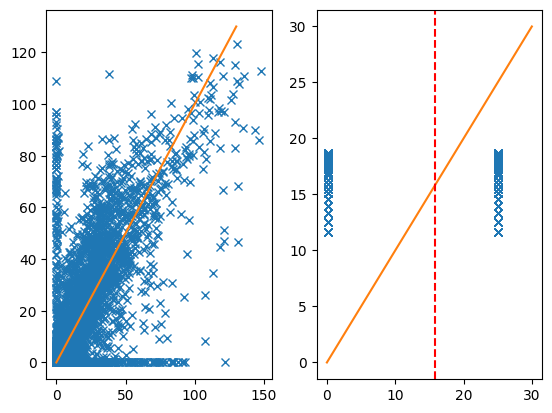


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28351      1      2   5632     0 15267   3.448D+00   3.835D+03
  F =   3835.0626775278124     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.730  0.412E+00    31968   110.09  0.430   [Radiance 0.660 micron]
     2  -1.298  0.458E+00    31968   110.09  0.430   [Radiance 0.660 micron]
     3  -1.658  0.480E+00    31968   110.09  0.430   [Radiance 0.660 micron]
     4  -1.912  0.294E+00    32115   110.72  0.433   [Radiance 0.660 micron]
     5  -2.267  0.162E+00    32895   113.

KeyboardInterrupt: 

In [25]:
warnings.filterwarnings('ignore')
for i in range(5):
    initial_gridded_extinction = solvers_reconstruct[0.66].medium['cloud'].density.data
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data*0 + 10
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))


    optimizer._options['maxiter'] = 1
    result = optimizer.minimize(x0)

    initial_gridded_extinction = solvers_reconstruct[0.66].medium['cloud'].density.data
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data*0 + 25
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))

    optimizer._options['maxiter'] = 1
    result = optimizer.minimize(x0)

### Under Estimate

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.369E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.331  0.407E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.657  0.417E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.892  0.263E+00    32083    40.24  0.157   [Radiance 0.660 micron]
     5  -2.203  0.152E+00    32718    44.16  0.173   [Radiance 0.660 micron]
     6  -2.251  0.890E-01    34541    54.19  0.212   [Radiance 0.660 micron]
     7  -2.373  0.652E-01    37061    66.58  0.260   [Radiance 0.660 micron]
     8  -2.438  0.503E-01    40069    79.45  0.310   [Radiance 0.660 micron]
     9  -2.543  0.418E-01    43410    91.88  0.359   [Radiance 0.660 micron]
    10  -2.600  0.348E-01    47851   105.64  0.413   [Radiance 0.660 micron]
    11  -2.706  0.302E-01    51845   115.91  0.453   [Radiance 0.660 micron]
    12  -3.008  0.300E-01    52188   116.69  0.456   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

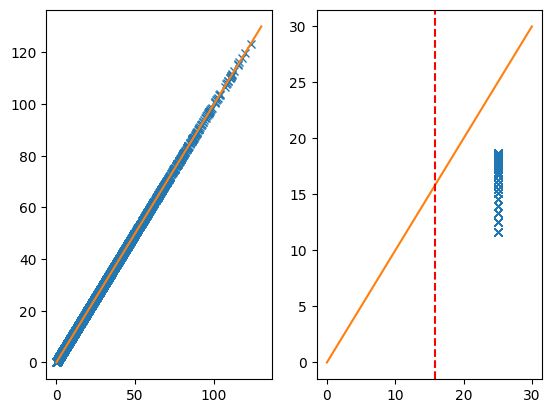

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.795  0.369E+00    31968   135.93  0.531   [Radiance 0.660 micron]
     2  -1.411  0.407E+00    31968   135.93  0.531   [Radiance 0.660 micron]
     3  -1.737  0.417E+00    31968   135.93  0.531   [Radiance 0.660 micron]
     4  -1.966  0.235E+00    32154   136.63  0.534   [Radiance 0.660 micron]
     5  -2.248  0.135E+00    32999   139.36  0.544   [Radiance 0.660 micron]
     6  -2.309  0.806E-01    35253   146.08  0.571   [Radiance 0.660 micron]
     7  -2.439  0.591E-01    38036   153.46  0.599   [Radiance 0.660 micron]
     8  -2.494  0.452E-01    41877   162.05  0.633   [Radiance 0.660 micron]
     9  -2.598  0.378E-01    45803   169.39  0.662   [Radiance 0.660 micron]
    10  -2.669  0.315E-01    50461   176.60  0.690   [Radiance 0.660 micron]
    11  -2.859  0.300E-01    52193   178.95  0.699   [Radiance 0.660 micron]
    12  -3.154  0.300E-01    52269   179.03  0.699   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

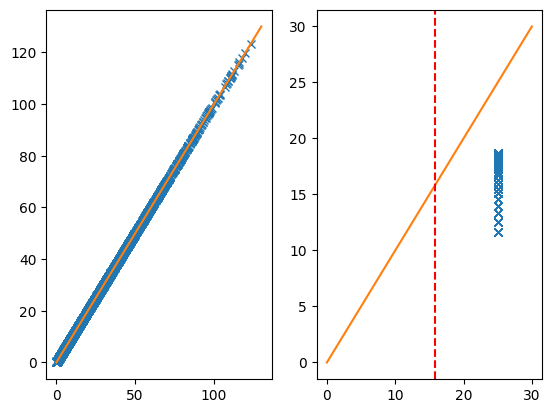

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.823  0.371E+00    31968   130.28  0.509   [Radiance 0.660 micron]
     2  -1.441  0.408E+00    31968   130.28  0.509   [Radiance 0.660 micron]
     3  -1.768  0.418E+00    31968   130.28  0.509   [Radiance 0.660 micron]
     4  -1.995  0.224E+00    32184   131.10  0.512   [Radiance 0.660 micron]
     5  -2.264  0.129E+00    33136   134.28  0.525   [Radiance 0.660 micron]
     6  -2.336  0.777E-01    35545   141.74  0.554   [Radiance 0.660 micron]
     7  -2.469  0.567E-01    38542   149.97  0.586   [Radiance 0.660 micron]
     8  -2.517  0.432E-01    42771   159.55  0.623   [Radiance 0.660 micron]
     9  -2.615  0.362E-01    46848   167.28  0.653   [Radiance 0.660 micron]
    10  -2.704  0.304E-01    51635   174.72  0.683   [Radiance 0.660 micron]
    11  -2.974  0.300E-01    52259   175.58  0.686   [Radiance 0.660 micron]
    12  -3.213  0.300E-01    52302   175.64  0.686   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

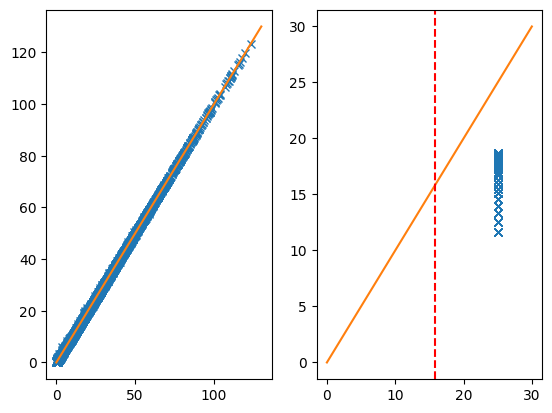

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.811  0.371E+00    31968   130.62  0.510   [Radiance 0.660 micron]
     2  -1.424  0.409E+00    31968   130.62  0.510   [Radiance 0.660 micron]
     3  -1.753  0.419E+00    31968   130.62  0.510   [Radiance 0.660 micron]
     4  -1.982  0.230E+00    32165   131.38  0.513   [Radiance 0.660 micron]
     5  -2.261  0.132E+00    33090   134.49  0.525   [Radiance 0.660 micron]
     6  -2.326  0.789E-01    35461   141.81  0.554   [Radiance 0.660 micron]
     7  -2.456  0.575E-01    38394   149.88  0.585   [Radiance 0.660 micron]
     8  -2.507  0.440E-01    42412   159.03  0.621   [Radiance 0.660 micron]
     9  -2.615  0.368E-01    46465   166.83  0.652   [Radiance 0.660 micron]
    10  -2.686  0.307E-01    51340   174.54  0.682   [Radiance 0.660 micron]
    11  -2.945  0.300E-01    52299   175.86  0.687   [Radiance 0.660 micron]
    12  -3.198  0.300E-01    52367   175.94  0.687   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

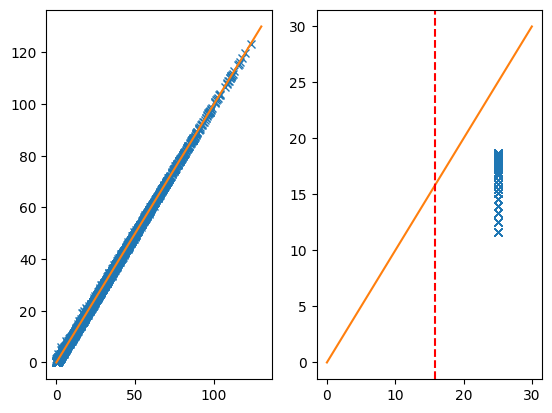

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.795  0.372E+00    31968   103.28  0.403   [Radiance 0.660 micron]
     2  -1.406  0.410E+00    31968   103.28  0.403   [Radiance 0.660 micron]
     3  -1.733  0.420E+00    31968   103.28  0.403   [Radiance 0.660 micron]
     4  -1.963  0.237E+00    32156   104.16  0.407   [Radiance 0.660 micron]
     5  -2.250  0.136E+00    32967   107.53  0.420   [Radiance 0.660 micron]
     6  -2.308  0.809E-01    35260   116.30  0.454   [Radiance 0.660 micron]
     7  -2.438  0.592E-01    38096   125.89  0.492   [Radiance 0.660 micron]
     8  -2.500  0.453E-01    41990   137.02  0.535   [Radiance 0.660 micron]
     9  -2.593  0.376E-01    46023   146.79  0.573   [Radiance 0.660 micron]
    10  -2.672  0.316E-01    50579   155.86  0.609   [Radiance 0.660 micron]
    11  -2.871  0.300E-01    52346   158.99  0.621   [Radiance 0.660 micron]
    12  -3.165  0.300E-01    52419   159.09  0.621   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

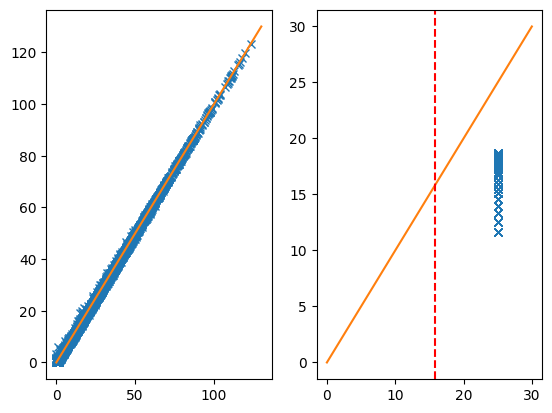

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.782  0.373E+00    31968    99.05  0.387   [Radiance 0.660 micron]
     2  -1.389  0.410E+00    31968    99.05  0.387   [Radiance 0.660 micron]
     3  -1.719  0.420E+00    31968    99.05  0.387   [Radiance 0.660 micron]
     4  -1.951  0.242E+00    32139    99.88  0.390   [Radiance 0.660 micron]
     5  -2.244  0.140E+00    32920   103.23  0.403   [Radiance 0.660 micron]
     6  -2.298  0.822E-01    35162   112.07  0.438   [Radiance 0.660 micron]
     7  -2.430  0.602E-01    37963   121.87  0.476   [Radiance 0.660 micron]
     8  -2.490  0.460E-01    41681   132.94  0.519   [Radiance 0.660 micron]
     9  -2.581  0.382E-01    45716   143.10  0.559   [Radiance 0.660 micron]
    10  -2.668  0.322E-01    50106   152.23  0.595   [Radiance 0.660 micron]
    11  -2.833  0.300E-01    52373   156.43  0.611   [Radiance 0.660 micron]
    12  -3.122  0.300E-01    52467   156.56  0.612   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

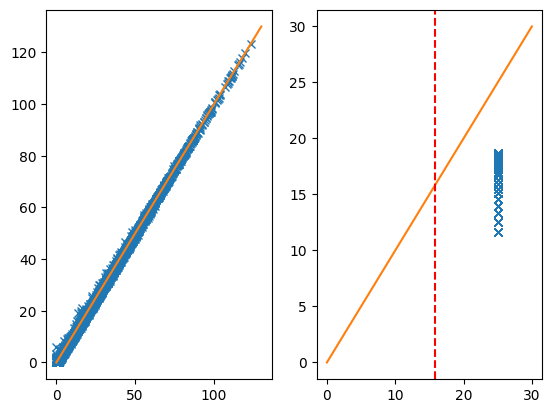

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.773  0.373E+00    31968    87.52  0.342   [Radiance 0.660 micron]
     2  -1.379  0.410E+00    31968    87.52  0.342   [Radiance 0.660 micron]
     3  -1.707  0.420E+00    31968    87.52  0.342   [Radiance 0.660 micron]
     4  -1.938  0.245E+00    32129    88.36  0.345   [Radiance 0.660 micron]
     5  -2.233  0.142E+00    32881    91.85  0.359   [Radiance 0.660 micron]
     6  -2.290  0.838E-01    35018   100.96  0.394   [Radiance 0.660 micron]
     7  -2.419  0.612E-01    37788   111.41  0.435   [Radiance 0.660 micron]
     8  -2.484  0.469E-01    41402   123.12  0.481   [Radiance 0.660 micron]
     9  -2.571  0.388E-01    45489   134.28  0.525   [Radiance 0.660 micron]
    10  -2.653  0.327E-01    49818   144.05  0.563   [Radiance 0.660 micron]
    11  -2.804  0.300E-01    52468   149.28  0.583   [Radiance 0.660 micron]
    12  -3.106  0.300E-01    52591   149.49  0.584   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

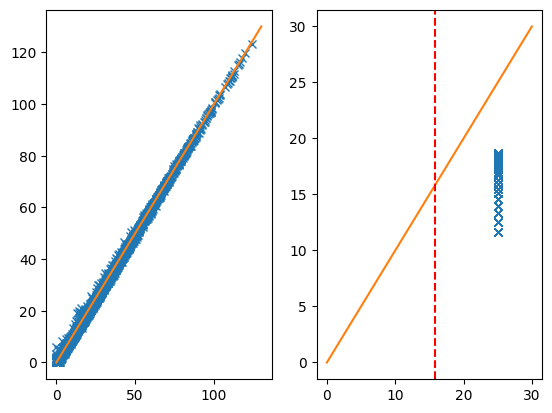

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.766  0.373E+00    31968    89.39  0.349   [Radiance 0.660 micron]
     2  -1.372  0.410E+00    31968    89.39  0.349   [Radiance 0.660 micron]
     3  -1.700  0.420E+00    31968    89.39  0.349   [Radiance 0.660 micron]
     4  -1.932  0.249E+00    32127    90.21  0.352   [Radiance 0.660 micron]
     5  -2.227  0.144E+00    32857    93.52  0.365   [Radiance 0.660 micron]
     6  -2.281  0.846E-01    34963   102.42  0.400   [Radiance 0.660 micron]
     7  -2.419  0.620E-01    37656   112.51  0.440   [Radiance 0.660 micron]
     8  -2.470  0.472E-01    41340   124.30  0.486   [Radiance 0.660 micron]
     9  -2.573  0.394E-01    45159   134.77  0.526   [Radiance 0.660 micron]
    10  -2.638  0.329E-01    49743   145.16  0.567   [Radiance 0.660 micron]
    11  -2.795  0.300E-01    52583   150.66  0.589   [Radiance 0.660 micron]
    12  -3.094  0.300E-01    52707   150.86  0.589   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

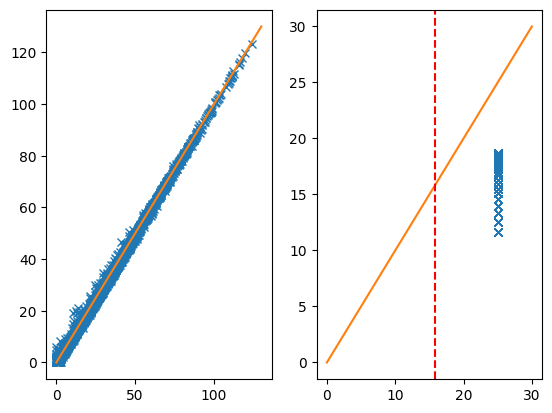

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.766  0.373E+00    31968    96.54  0.377   [Radiance 0.660 micron]
     2  -1.372  0.411E+00    31968    96.54  0.377   [Radiance 0.660 micron]
     3  -1.699  0.421E+00    31968    96.54  0.377   [Radiance 0.660 micron]
     4  -1.931  0.249E+00    32127    97.32  0.380   [Radiance 0.660 micron]
     5  -2.225  0.144E+00    32861   100.50  0.393   [Radiance 0.660 micron]
     6  -2.280  0.849E-01    34942   108.97  0.426   [Radiance 0.660 micron]
     7  -2.416  0.621E-01    37678   118.81  0.464   [Radiance 0.660 micron]
     8  -2.466  0.473E-01    41359   130.08  0.508   [Radiance 0.660 micron]
     9  -2.578  0.396E-01    45153   140.02  0.547   [Radiance 0.660 micron]
    10  -2.638  0.329E-01    49872   150.28  0.587   [Radiance 0.660 micron]
    11  -2.790  0.300E-01    52653   155.43  0.607   [Radiance 0.660 micron]
    12  -3.094  0.300E-01    52783   155.63  0.608   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

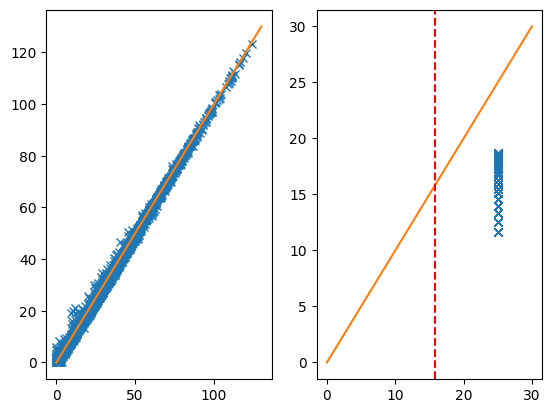

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.767  0.374E+00    31968   101.20  0.395   [Radiance 0.660 micron]
     2  -1.375  0.411E+00    31968   101.20  0.395   [Radiance 0.660 micron]
     3  -1.702  0.421E+00    31968   101.20  0.395   [Radiance 0.660 micron]
     4  -1.933  0.249E+00    32131   101.98  0.398   [Radiance 0.660 micron]
     5  -2.225  0.143E+00    32890   105.17  0.411   [Radiance 0.660 micron]
     6  -2.281  0.847E-01    34977   113.42  0.443   [Radiance 0.660 micron]
     7  -2.415  0.620E-01    37718   123.02  0.481   [Radiance 0.660 micron]
     8  -2.465  0.473E-01    41443   134.12  0.524   [Radiance 0.660 micron]
     9  -2.586  0.396E-01    45238   143.75  0.562   [Radiance 0.660 micron]
    10  -2.633  0.327E-01    50102   153.94  0.601   [Radiance 0.660 micron]
    11  -2.799  0.300E-01    52780   158.73  0.620   [Radiance 0.660 micron]
    12  -3.092  0.300E-01    52893   158.90  0.621   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

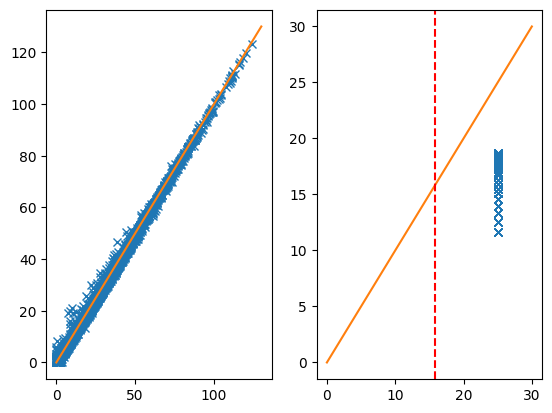


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
28350     10     11   9598     0 15258   1.616D-02   1.138D+01
  F =   11.380820644792399     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [10]:
# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

grid_to_optical_properties._fixed_dataset["reff"] = solvers[0.66].medium['cloud'].reff*0 + 25
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(grid_to_optical_properties,
    density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)))
)
# now we form state_gen which updates the solvers with an input_state.

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                        unknown_scatterers, surfaces,
                                        numerical_parameters, sources, background_optical_scatterers,
                                        num_stokes)
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()

warnings.filterwarnings('ignore')
initial_gridded_extinction = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)
initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
x0 = state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction)
objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)

optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 30, 'maxls': 10, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-8})

optimizer._options['maxiter'] = 10
result = optimizer.minimize(x0)